In [1]:
import os
import re
import statistics
import pickle
import itertools
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot
from upsetplot import UpSet, from_contents
from tqdm import tqdm

import score_utils

## Import Datasets

### Import ProbCBR

#### importing function

In [2]:
# Import probCBR res
def json_to_df(json_dir: str) -> pd.DataFrame:
    """
    Takes a string to a json object and turns it into a dataframe
    """
    # import the json object
    with open(json_dir, "r") as f:
        json_obj = json.load(f)

    # creates a dict with json keys as keys and values of emptylist based on the first json entry
    json_key_dict = {i: [] for i in list(json_obj[0].keys())}
    for i in json_obj:
        for j in json_key_dict.keys():
            # add j key in json item i to the list
            to_add = json_key_dict[j]
            to_add.append(i[j])
            json_key_dict.update({j: to_add})

    return pd.DataFrame(json_key_dict)

In [3]:
pcbr_df = json_to_df("/home/msinha/Open-BIo-Link/data1.json")
pcbr_df.head(2)

,e1,r,answers,predicted_answers
0,CHEBI:135735,indication,[DOID:10763],"[DOID:6432, DOID:6000, DOID:10763, DOID:10591,..."
1,DOID:10763,indication_inv,"[CHEBI:135735, CHEBI:135738, CHEBI:141521, CHE...","[CHEBI:31548, CHEBI:46632, CHEBI:5784, CHEBI:5..."


#### process the dataframe

In [4]:
def process_dataframe(
    df: pd.DataFrame,
    data_dir: str,
    model_dir: str,
    mode: str = "tail-batch",
    rel=[
        "indication",
        "indication_CiD",
    ],
):
    """
    Gets True tail triples
    """

    # get true head/tail triples from graph
    raw = score_utils.ProcessOutput(
        data_dir=data_dir,
        scores_outfile=os.path.join(model_dir, "test_scores.tsv"),
        mode=mode,
    )
    graph = raw.get_true_targets()
    graph = graph.query("r in @rel")

    if mode == "tail-batch":
        # get true tail triples from graph

        merged = pd.merge(
            left=df[["e1", "r", "answers", "predicted_answers"]].rename(
                columns={"e1": "h"}
            ),
            right=graph,
            how="left",
            on=["h", "r"],
        )
        merged = merged.rename(columns={"t": "true_t"})

        # ensure answers is in 'true_t'. First remove all predicted answers with no predictions
        merged = merged[merged["predicted_answers"].apply(lambda x: len(x) > 0)]
        # add answers to true t
        merged["true_t"] = [
            list(set(val) | set(merged.answers.iloc[ind]))
            if type(val) != float
            else list(set(merged.answers.iloc[ind]))
            for ind, val in enumerate(merged.true_t)
        ]

    elif mode == "head-batch":
        # get True head triples from graph
        merged = pd.merge(
            left=df[["e1", "r", "answers", "predicted_answers"]].rename(
                columns={"e1": "t"}
            ),
            right=graph,
            how="left",
            on=["r", "t"],
        )
        merged = merged.rename(columns={"t": "true_h", "h": "t"})

        # ensure answers is in 'true_t'. First remove all predicted answers with no predictions
        merged = merged[merged["predicted_answers"].apply(lambda x: len(x) > 0)]
        # add answers to true t
        merged["true_h"] = [
            list(set(val) | set(merged.answers.iloc[ind]))
            if type(val) != float
            else list(set(merged.answers.iloc[ind]))
            for ind, val in enumerate(merged.true_h)
        ]

    else:
        raise ValueError(f'{batch} is not in {"head-batch","tail-batch"}')
    return merged


def flatten_list(a_ls: list) -> list:
    """
    given a list of list, flatten to a 1D list
    """
    return_ls = list()
    for i in a_ls:
        min_ls = list()
        for j in i:
            if type(j) == list:
                for k in j:
                    min_ls.append(k)
            else:
                min_ls.append(j)
        min_ls = list(set(min_ls))
        return_ls.append(min_ls)

    return return_ls


# ensure answers are in true_t


def add_list_to_list(ls1: list, ls2: list) -> list:
    """
    Given two lists of lists, add list from ls1 to ls2 at the same index
    ls1: list to add to another list
    ls2: list to extend
    """

    for i, val in enumerate(ls1):
        ls2_item = ls2[i]
        ls2_item.extend(val)
        ls2[i] = list(set(ls2_item))

    return ls2

In [5]:
## get indications only
pcbr_df = process_dataframe(
    df=pcbr_df,
    data_dir="../data/MIND_CtD/",
    model_dir="../models/TransE_MIND_CtD_megha",
)

# note that true_t are all unique answers
pcbr_df = pcbr_df.query('r=="indication"')

In [6]:
# flatten true_t
pcbr_df.true_t = flatten_list(pcbr_df.true_t)
pcbr_df.true_t = add_list_to_list(list(pcbr_df.answers), list(pcbr_df.true_t))
pcbr_df["algo"] = "pCBR"

pcbr_df.head(2)

,h,r,answers,predicted_answers,true_t,algo
0,CHEBI:135735,indication,[DOID:10763],"[DOID:6432, DOID:6000, DOID:10763, DOID:10591,...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",pCBR
2,CHEBI:135738,indication,[DOID:10763],"[DOID:10763, DOID:446, DOID:10591, DOID:10824,...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",pCBR


### Import CBR

In [7]:
cbr_df = json_to_df("/home/msinha/CBR-AKBC/results/data_CBRonMIND_CtD.json")
cbr_df = process_dataframe(
    df=cbr_df, data_dir="../data/MIND_CtD", model_dir="../models/TransE_MIND_CtD_megha/"
)
# ensure answers are in true_t
cbr_df.true_t = flatten_list(list(cbr_df.true_t))
cbr_df.true_t = add_list_to_list(list(cbr_df.answers), list(cbr_df.true_t))
cbr_df["algo"] = "CBR"
cbr_df.head(2)

,h,r,answers,predicted_answers,true_t,algo
0,CHEBI:135735,indication,[DOID:10763],"[DOID:3393, DOID:6000, DOID:10763, DOID:3683, ...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",CBR
1,CHEBI:135738,indication,[DOID:10763],"[HP:0000006, HP:0000007, HP:0001425, HP:000142...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",CBR


### Import Rephetio Results

In [8]:
raw = score_utils.ProcessOutput(
    data_dir="../data/MIND_CtD/",
    scores_outfile=os.path.join("../models/TransE_MIND_CtD_megha/", "test_scores.tsv"),
    mode="tail-batch",
)
known_triples = raw.get_true_targets()
known_triples = known_triples.query("r == 'indication' or r == 'indication_CiD'")

# get unique chemicalsubstances and group the items togeher
rephetio = (
    pd.read_csv(
        "../../MechRepoNet/1_code/KG_reasoning_comparison/Rephetio_MIND_CtD_test/results.csv"
    )
    .sort_values(by="proba", ascending=False)
    .groupby("chemicalsubstance_id")
    .agg(lambda x: list(x))
    .reset_index()
    .rename(columns={"chemicalsubstance_id": "h", "disease_id": "predicted_answers"})[
        ["h", "predicted_answers", "proba"]
    ]
)

rephetio["algo"] = "Rephetio"

# merge known answers with rephetio to get a list of known answers per chemical compound. Just formatting
rephetio = pd.merge(left=rephetio, right=known_triples, on="h", how="left").rename(
    columns={"t": "answers"}
)[["h", "predicted_answers", "answers", "proba", "algo"]]

rephetio.head(2)

,h,predicted_answers,answers,proba,algo
0,CHEBI:135735,"[DOID:10763, DOID:5844, DOID:10825, DOID:2559,...","[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[0.6733899229161452, 0.1993276939787308, 0.091...",Rephetio
1,CHEBI:135738,"[DOID:10763, DOID:0060224, DOID:10825, DOID:58...","[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[0.9325203250946036, 0.780770655712133, 0.5917...",Rephetio


In [9]:
# limit predicted answers to top 100
rephetio["predicted_answers"] = rephetio["predicted_answers"].apply(lambda x: x[0:100])
rephetio.predicted_answers.apply(lambda x: len(x)).describe()

count    374.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: predicted_answers, dtype: float64

### Import KGE Results

In [10]:
kge_ls = list()
for i in ["TransE", "DistMult", "ComplEx", "RotatE"]:
    print(i)
    raw = score_utils.ProcessOutput(
        data_dir="../data/MIND_CtD",
        scores_outfile=f"../models/{i}_MIND_CtD_megha/test_scores.tsv",
        mode="tail-batch",
    )
    raw.format_raw_scores_to_df()
    raw.translate_embeddings(direction="from")

    df = raw.filter_predictions(top=100).query('batch=="tail-batch"')
    # limit to top 100
    df["preds"] = df["preds"].apply(lambda x: x[0:100])
    df["algo"] = i
    kge_ls.append(df)
    print(f"Shape: {df.shape}")

TransE
Shape: (537, 7)
DistMult
Shape: (1074, 7)
ComplEx
Shape: (537, 7)
RotatE
Shape: (537, 7)


In [11]:
kge_df = pd.concat(kge_ls)
kge_df.head(2)

,h,r,preds,batch,true_t,filt_preds,algo
537,CHEBI:135735,indication,"[CHEBI:135735, DOID:9654, UMLS:C0221155, WD:Q2...",tail-batch,"[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[DOID:9654, UMLS:C0221155, WD:Q25303605, MONDO...",TransE
538,CHEBI:135738,indication,"[CHEBI:135738, DOID:10763, DOID:9654, WD:Q2530...",tail-batch,"[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[DOID:9654, WD:Q25303605, UMLS:C0221155, CHEBI...",TransE


In [12]:
# Drop duplicate compounds, all predictions are the same given compound and model
print(f"Before duplicate removal: {kge_df.shape}")
kge_df = kge_df.drop_duplicates(subset=["h", "r", "algo"])
print(f"After: {kge_df.shape}")

Before duplicate removal: (2685, 7)
After: (1548, 7)


## Unify all headers and clean up the data

In [13]:
# cbr and rephetio don't yield results for some of the compound disease predictions
(
    len(
        set(pcbr_df["h"])
        .intersection(set(cbr_df["h"]))
        .intersection(set(rephetio["h"]))
        .intersection(set(kge_df.query('algo=="TransE"')["h"]))
    )
)

322

In [14]:
intersection_ls = list(
    set(pcbr_df["h"])
    .intersection(set(cbr_df["h"]))
    .intersection(set(rephetio["h"]))
    .intersection(set(kge_df.query('algo=="TransE"')["h"]))
)

cbr_df = cbr_df.explode(column="answers").query("h in @intersection_ls")
cbr_df.shape

(460, 6)

In [15]:
pcbr_df = pcbr_df.explode(column="answers").query("h in @intersection_ls")
pcbr_df.shape

(460, 6)

In [16]:
rephetio_df = rephetio[["h", "predicted_answers", "algo"]]

# reorganize the dataframe and merge in true_answer
rephetio_df = pd.merge(
    left=rephetio_df,
    right=cbr_df[["h", "r", "answers", "true_t"]],
    on="h",
    how="right",
)[["h", "r", "answers", "predicted_answers", "true_t", "algo"]]

rephetio_df.head(1)

,h,r,answers,predicted_answers,true_t,algo
0,CHEBI:135735,indication,DOID:10763,"[DOID:10763, DOID:5844, DOID:10825, DOID:2559,...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",Rephetio


In [17]:
rephetio_df.shape

(460, 6)

In [18]:
# groupby cbr again..
cbr_df_groupby = cbr_df[["h", "answers"]].groupby("h").agg(list)

In [19]:
# reogranize kge df
kge_df = (
    pd.merge(left=kge_df, right=cbr_df_groupby, on="h", how="left")
    .query("h in @intersection_ls")[["h", "r", "answers", "preds", "true_t", "algo"]]
    .explode("answers")
)

In [20]:
# combine all df together
combined_df = pd.concat(
    [
        cbr_df,
        pcbr_df,
        rephetio_df,
        kge_df.rename(columns={"preds": "predicted_answers"}),
    ]
)
combined_df.shape

(3220, 6)

In [21]:
# Get a consolidated list of Trues
get_h2targets = (
    combined_df[["h", "true_t"]]
    .explode("true_t")
    .groupby("h")
    .agg(lambda x: list(set(x)))
    .reset_index()
)

In [22]:
# create a dict to relabel true_ts
new_true_dict = dict(zip(get_h2targets["h"], get_h2targets["true_t"]))

combined_df["true_t2"] = [
    new_true_dict[val] for i, val in enumerate(list(combined_df["h"]))
]
combined_df.shape

(3220, 7)

In [23]:
combined_df["t_equal_t2"] = [
    set(list(combined_df["true_t"])[i]).issubset(set(val))
    for i, val in enumerate(list(combined_df["true_t2"]))
]

In [24]:
combined_df.query("t_equal_t2==False")

,h,r,answers,predicted_answers,true_t,algo,true_t2,t_equal_t2


In [25]:
# reset the indices after concatinations
combined_df = combined_df.reset_index()[
    ["h", "r", "answers", "predicted_answers", "true_t", "algo"]
]

In [26]:
combined_df.head(2)

,h,r,answers,predicted_answers,true_t,algo
0,CHEBI:135735,indication,DOID:10763,"[DOID:3393, DOID:6000, DOID:10763, DOID:3683, ...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",CBR
1,CHEBI:135738,indication,DOID:10763,"[HP:0000006, HP:0000007, HP:0001425, HP:000142...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",CBR


## UpsetPlot setup

In [27]:
# for some reason the plot_shading function wasn't working for me, so I edit it by creating a new subclass
class upsetplot2(UpSet):
    def __init__(self, *args, **kwargs):
        super(upsetplot2, self).__init__(*args, **kwargs)

    def plot_shading(self, ax):
        for i in range(0, len(self.totals), 2):
            if i % 2 == 0:
                rect = plt.Rectangle(
                    self._swapaxes(0, i - 0.4),
                    *self._swapaxes(*(1, 0.8)),
                    facecolor=self._shading_color,
                    lw=0,
                    zorder=0
                )
                ax.add_patch(rect)

        ax.set_frame_on(False)
        ax.tick_params(
            axis="both",
            which="both",
            left=False,
            right=False,
            bottom=False,
            top=False,
            labelbottom=False,
            labelleft=False,
        )
        ax.grid(False)
        # ax.set_xticks([])
        # ax.set_yticks([])
        # ax.set_xticklabels([])
        # ax.set_yticklabels([])

## Get dataset intersections

In [28]:
# get a list of tuples of all combinations of algorithm results
algos = ["CBR", "pCBR", "Rephetio", "TransE", "DistMult", "ComplEx", "RotatE"]
algo_combos = [
    j
    for i in [
        list(itertools.combinations(algos, combo_sz))
        for combo_sz in range(2, len(algos) + 1)
    ]
    for j in i
]

In [29]:
print(f"Before removing duplicate compounds: {combined_df.shape}")
combined_df = combined_df.drop_duplicates(["h", "algo"])
print(f"After removing duplicae compounds: {combined_df.shape}")

Before removing duplicate compounds: (3220, 6)
After removing duplicae compounds: (2254, 6)


In [30]:
combined_df

,h,r,answers,predicted_answers,true_t,algo
0,CHEBI:135735,indication,DOID:10763,"[DOID:3393, DOID:6000, DOID:10763, DOID:3683, ...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",CBR
1,CHEBI:135738,indication,DOID:10763,"[HP:0000006, HP:0000007, HP:0001425, HP:000142...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",CBR
2,CHEBI:135876,indication,DOID:11054,"[DOID:0050861, DOID:10283, MESH:D008106, DOID:...","[DOID:11054, DOID:11814, DOID:11818, DOID:1181...",CBR
3,CHEBI:135923,indication,DOID:14499,"[DOID:684, MESH:D008106, DOID:60052, MESH:D056...",[DOID:14499],CBR
4,CHEBI:135925,indication,DOID:1094,"[DOID:60080, DOID:60075, DOID:1612, DOID:60164...","[MESH:D056912, DOID:1094]",CBR
...,...,...,...,...,...,...
3214,IKEY:COCFEDIXXNGUNL-RFKWWTKHSA-N,indication,DOID:9744,"[DOID:9744, DOID:446, DOID:10603, MESH:D011297...",[DOID:9744],RotatE
3215,IKEY:CSRKRWYVFHQLNJ-UIEAZXIASA-N,indication,DOID:1067,"[DOID:11150, GO:0016020, GO:0016021, NCBITaxon...","[DOID:1066, DOID:1070, DOID:13544, DOID:1067, ...",RotatE
3217,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,indication,DOID:9119,"[WD:Q53910821, WD:Q4677939, MESH:D015472, WD:Q...","[DOID:0060318, DOID:8761, DOID:8864, WD:Q11101...",RotatE
3218,IKEY:XYGBKMMCQDZQOZ-UHFFFAOYSA-M,indication,DOID:8986,"[GO:0016853, GO:0046872, NCBITaxon:5833, GO:00...",[DOID:8986],RotatE


In [31]:
def get_rank(to_rank: list, predict_ls: list, filter_rank: bool = False) -> dict:
    """
    Gets rank of items in 'to_rank' from positions in 'ls_combo', a list of lists as a dict. The parameter `filter_rank` applies only for when multiple true answers are known, otherwise should default to False.

    ex
    get_rank(to_rank = ['DOID:1234'], predict_ls = [.,.,.,.,'DOID:1234'], filter = False) -> {'DOID:1234':5}
    """
    rank_dict = dict()
    for ent in to_rank:
        try:
            rank_dict.update({ent: predict_ls.index(ent) + 1})
        except:
            next

    if filter_rank:
        # iterate through the dict, subtract number of ranks prior to rank
        vals = list(rank_dict.values())
        rank_dict = dict(
            zip(rank_dict.keys(), [val - sorted(vals).index(val) for val in vals])
        )

    return rank_dict


def prediction_iterator(
    df: pd.DataFrame = combined_df,
    algo_combo: tuple = ("CBR", "pCBR"),
):
    """
    queries dataframe for model listed in tuple, "algo_combo" and extracts the INTERSECTION of each indication predictions
    """
    # get unique compound list
    unique_compounds = list(set(df.h))
    filt_df = df.query("algo in @algo_combo")

    predicted_answers_rank = dict()

    # get disease ranks per method
    # predicted answers for two methods example
    # [{'CHEBI:123':5 ...},{'CHEBI:123':10 ...}]
    for compound in unique_compounds:
        filt_filt_df = filt_df.query("h==@compound")
        intersect_items = set.intersection(
            *map(set, [list(preds) for preds in list(filt_filt_df.predicted_answers)])
        )

        predicted_answers_rank.update(
            {
                compound: [
                    get_rank(list(intersect_items), preds)
                    for preds in list(filt_filt_df.predicted_answers)
                ]
            }
        )

    # condense ranks so you get 1 key to list of ranks
    final_dict = dict()
    for compounds, disease_ls in predicted_answers_rank.items():
        overlap_dict = dict()
        for dis_method in disease_ls:
            for k, v in dis_method.items():
                try:
                    old_v = overlap_dict[k]
                    old_v.append(v)
                    overlap_dict.update({k: old_v})
                except:
                    overlap_dict[k] = [v]
        final_dict.update({compounds: overlap_dict})

    return final_dict

In [32]:
assert len(x := (prediction_iterator(algo_combo=("CBR", "pCBR", "TransE")))) == 322
assert len(x["CHEBI:9334"]["DOID:3908"]) == 3

In [33]:
# incredibly slow since I used 3 nested For loops SMH..
algo_combo_dict = {
    algos: prediction_iterator(df=combined_df, algo_combo=algos)
    for algos in tqdm(iterable=algo_combos, total=len(algo_combos))
}

100%|████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:42<00:00,  2.83it/s]


In [34]:
rank_df = pd.DataFrame(
    {
        "algos": [k for k, v in algo_combo_dict.items() for i in range(0, len(v))],
        "compounds": [i for v in algo_combo_dict.values() for i in v.keys()],
        "intersect_rk": [i for v in algo_combo_dict.values() for i in v.values()],
    }
)
rank_df

,algos,compounds,intersect_rk
0,"(CBR, pCBR)",CHEBI:3023,"{'DOID:0050700': [80, 25], 'DOID:12849': [57, ..."
1,"(CBR, pCBR)",CHEBI:567361,"{'DOID:2841': [34, 6], 'DOID:7148': [66, 12], ..."
2,"(CBR, pCBR)",CHEBI:9334,"{'DOID:11054': [60, 32], 'DOID:4450': [86, 41]..."
3,"(CBR, pCBR)",CHEBI:3216,"{'DOID:2841': [55, 46], 'DOID:1826': [34, 44],..."
4,"(CBR, pCBR)",CHEBI:5801,"{'DOID:7148': [31, 1], 'DOID:3770': [63, 98], ..."
...,...,...,...
38635,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:32087,{}
38636,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:28445,{}
38637,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:15854,{}
38638,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:61030,{}


### extract true diseases and append to dataframe

In [35]:
rank_df = pd.merge(
    left=rank_df,
    right=combined_df.query('algo=="CBR"')[["h", "true_t"]],
    left_on="compounds",
    right_on="h",
    how="left",
)[["algos", "compounds", "intersect_rk", "true_t"]]

rank_df

,algos,compounds,intersect_rk,true_t
0,"(CBR, pCBR)",CHEBI:3023,"{'DOID:0050700': [80, 25], 'DOID:12849': [57, ...",[DOID:13189]
1,"(CBR, pCBR)",CHEBI:567361,"{'DOID:2841': [34, 6], 'DOID:7148': [66, 12], ...","[DOID:6354, DOID:0050784, DOID:1039, DOID:2378..."
2,"(CBR, pCBR)",CHEBI:9334,"{'DOID:11054': [60, 32], 'DOID:4450': [86, 41]...","[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85..."
3,"(CBR, pCBR)",CHEBI:3216,"{'DOID:2841': [55, 46], 'DOID:1826': [34, 44],...","[DOID:2559, DOID:11206]"
4,"(CBR, pCBR)",CHEBI:5801,"{'DOID:7148': [31, 1], 'DOID:3770': [63, 98], ...","[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303..."
...,...,...,...,...
38635,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:32087,{},[DOID:4481]
38636,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:28445,{},"[DOID:6354, DOID:0050873, DOID:706, DOID:1037,..."
38637,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:15854,{},"[DOID:14325, DOID:14068, DOID:12978, DOID:1432..."
38638,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:61030,{},[DOID:893]


### Append true ranks and the contrary to the dataframe

In [36]:
# get true_t ranks

extracted_trues = [
    {
        dis: rank_df.intersect_rk[i][dis]
        for dis in lists
        if dis in list(rank_df.intersect_rk)[i].keys()
    }
    for i, lists in enumerate(
        tqdm(list(rank_df.true_t)),
    )
]

100%|████████████████████████████████████████████████████████████████████████████████| 38640/38640 [11:03<00:00, 58.27it/s]


In [37]:
# non-trues

non_true_ls = list()
for i, lists in enumerate(list(rank_df.true_t)):
    cur_dict = rank_df.intersect_rk[i]
    for dis in lists:
        try:
            del cur_dict[dis]
        except:
            next

    non_true_ls.append(cur_dict)

In [38]:
len(non_true_ls[0])

2

In [39]:
rank_df.true_t.iloc[0]

['DOID:13189']

In [40]:
# append trues and non-trues to df

rank_df["true_rk"] = extracted_trues
rank_df["!true_rk"] = non_true_ls
rank_df.head()

,algos,compounds,intersect_rk,true_t,true_rk,!true_rk
0,"(CBR, pCBR)",CHEBI:3023,"{'DOID:0050700': [80, 25], 'DOID:12849': [57, ...",[DOID:13189],{},"{'DOID:0050700': [80, 25], 'DOID:12849': [57, ..."
1,"(CBR, pCBR)",CHEBI:567361,"{'DOID:2841': [34, 6], 'DOID:7148': [66, 12], ...","[DOID:6354, DOID:0050784, DOID:1039, DOID:2378...","{'MESH:D002471': [42, 56]}","{'DOID:2841': [34, 6], 'DOID:7148': [66, 12], ..."
2,"(CBR, pCBR)",CHEBI:9334,"{'DOID:11054': [60, 32], 'DOID:4450': [86, 41]...","[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85...","{'DOID:7148': [32, 54], 'DOID:8577': [98, 1]}","{'DOID:11054': [60, 32], 'DOID:4450': [86, 41]..."
3,"(CBR, pCBR)",CHEBI:3216,"{'DOID:2841': [55, 46], 'DOID:1826': [34, 44],...","[DOID:2559, DOID:11206]",{},"{'DOID:2841': [55, 46], 'DOID:1826': [34, 44],..."
4,"(CBR, pCBR)",CHEBI:5801,"{'DOID:3770': [63, 98], 'DOID:8577': [45, 35]}","[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303...","{'DOID:7148': [31, 1]}","{'DOID:3770': [63, 98], 'DOID:8577': [45, 35]}"


In [41]:
rank_df.shape

(38640, 6)

### Calculate Average and reciprocal rank

In [42]:
rank_df["avg_ind_rnk"] = [
    {k: sum(v) / len(v) for k, v in dicts.items()} for dicts in list(rank_df.true_rk)
]
rank_df["avg_not_ind_rnk"] = [
    {k: sum(v) / len(v) for k, v in dicts.items()}
    for dicts in list(rank_df["!true_rk"])
]
rank_df["rr_ind"] = [
    {k: sum([1 / i for i in v]) / len(v) for k, v in dicts.items()}
    for dicts in list(rank_df.true_rk)
]
rank_df["rr_not_ind"] = [
    {k: sum([1 / i for i in v]) / len(v) for k, v in dicts.items()}
    for dicts in list(rank_df["!true_rk"])
]

In [43]:
rank_df

,algos,compounds,intersect_rk,true_t,true_rk,!true_rk,avg_ind_rnk,avg_not_ind_rnk,rr_ind,rr_not_ind
0,"(CBR, pCBR)",CHEBI:3023,"{'DOID:0050700': [80, 25], 'DOID:12849': [57, ...",[DOID:13189],{},"{'DOID:0050700': [80, 25], 'DOID:12849': [57, ...",{},"{'DOID:0050700': 52.5, 'DOID:12849': 61.0}",{},"{'DOID:0050700': 0.026250000000000002, 'DOID:1..."
1,"(CBR, pCBR)",CHEBI:567361,"{'DOID:2841': [34, 6], 'DOID:7148': [66, 12], ...","[DOID:6354, DOID:0050784, DOID:1039, DOID:2378...","{'MESH:D002471': [42, 56]}","{'DOID:2841': [34, 6], 'DOID:7148': [66, 12], ...",{'MESH:D002471': 49.0},"{'DOID:2841': 20.0, 'DOID:7148': 39.0, 'DOID:5...",{'MESH:D002471': 0.020833333333333332},"{'DOID:2841': 0.09803921568627451, 'DOID:7148'..."
2,"(CBR, pCBR)",CHEBI:9334,"{'DOID:11054': [60, 32], 'DOID:4450': [86, 41]...","[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85...","{'DOID:7148': [32, 54], 'DOID:8577': [98, 1]}","{'DOID:11054': [60, 32], 'DOID:4450': [86, 41]...","{'DOID:7148': 43.0, 'DOID:8577': 49.5}","{'DOID:11054': 46.0, 'DOID:4450': 63.5, 'DOID:...","{'DOID:7148': 0.02488425925925926, 'DOID:8577'...","{'DOID:11054': 0.02395833333333333, 'DOID:4450..."
3,"(CBR, pCBR)",CHEBI:3216,"{'DOID:2841': [55, 46], 'DOID:1826': [34, 44],...","[DOID:2559, DOID:11206]",{},"{'DOID:2841': [55, 46], 'DOID:1826': [34, 44],...",{},"{'DOID:2841': 50.5, 'DOID:1826': 39.0, 'DOID:1...",{},"{'DOID:2841': 0.019960474308300395, 'DOID:1826..."
4,"(CBR, pCBR)",CHEBI:5801,"{'DOID:3770': [63, 98], 'DOID:8577': [45, 35]}","[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303...","{'DOID:7148': [31, 1]}","{'DOID:3770': [63, 98], 'DOID:8577': [45, 35]}",{'DOID:7148': 16.0},"{'DOID:3770': 80.5, 'DOID:8577': 40.0}",{'DOID:7148': 0.5161290322580645},"{'DOID:3770': 0.013038548752834465, 'DOID:8577..."
...,...,...,...,...,...,...,...,...,...,...
38635,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:32087,{},[DOID:4481],{},{},{},{},{},{}
38636,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:28445,{},"[DOID:6354, DOID:0050873, DOID:706, DOID:1037,...",{},{},{},{},{},{}
38637,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:15854,{},"[DOID:14325, DOID:14068, DOID:12978, DOID:1432...",{},{},{},{},{},{}
38638,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:61030,{},[DOID:893],{},{},{},{},{},{}


### build upset plot combos

In [44]:
len_algo_rank_dict = dict(
    zip(rank_df.algos, [len(l.keys()) for l in rank_df.intersect_rk])
)

In [45]:
n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in len_algo_rank_dict.items()],
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
)

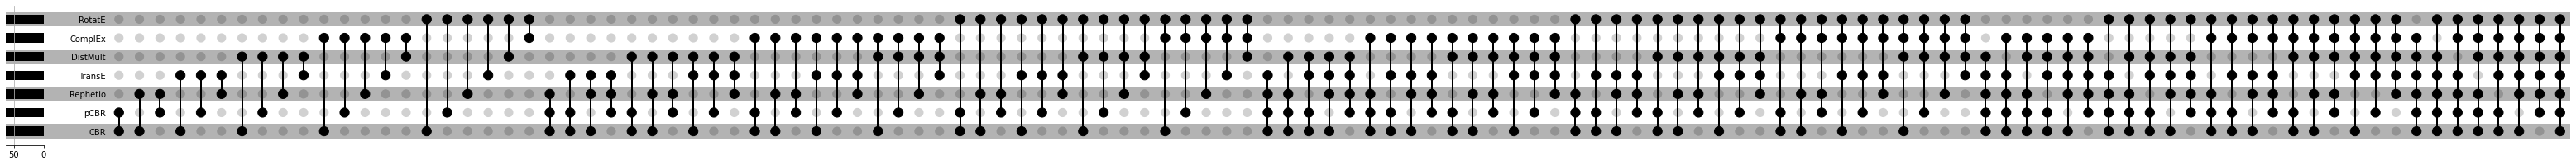

In [46]:
n

## Plot Average Rank

In [47]:
# mean rank
mean_rank_df = rank_df[["algos", "avg_ind_rnk", "avg_not_ind_rnk"]]
mean_rank_df = mean_rank_df.rename(
    columns={"avg_ind_rnk": "Indication", "avg_not_ind_rnk": "!Indication"}
)

mean_rank_df["Indication"] = mean_rank_df.Indication.apply(lambda x: list(x.values()))
mean_rank_df["!Indication"] = mean_rank_df["!Indication"].apply(
    lambda x: list(x.values())
)

In [48]:
# get an index for algo combinations
order = pd.DataFrame(n.intersections).reset_index()

tup_ls = list()
for i in range(0, order.shape[0], 1):
    als = list()
    for algo in ["CBR", "pCBR", "Rephetio", "TransE", "DistMult", "ComplEx", "RotatE"]:
        if order[algo].iloc[i]:
            als.append(algo)
    tup_ls.append(tuple(als))

order["algos"] = tup_ls
order["ind"] = [i for i in range(0, order.shape[0])]

order_algo_dict = dict(
    zip(order["algos"], order["ind"])
)  # algo combos to upsetplot index loc

In [49]:
mean_rank_df

,algos,Indication,!Indication
0,"(CBR, pCBR)",[],"[52.5, 61.0]"
1,"(CBR, pCBR)",[49.0],"[20.0, 39.0, 57.5, 4.5, 56.5, 43.0, 23.0, 50.0]"
2,"(CBR, pCBR)","[43.0, 49.5]","[46.0, 63.5, 62.0, 59.0, 75.5, 30.5, 63.5, 32...."
3,"(CBR, pCBR)",[],"[50.5, 39.0, 54.5, 3.5, 78.0, 74.0, 66.5, 93.0..."
4,"(CBR, pCBR)",[16.0],"[80.5, 40.0]"
...,...,...,...
38635,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",[],[]
38636,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",[],[]
38637,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",[],[]
38638,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",[],[]


In [50]:
mean_rank_df["ind"] = mean_rank_df.algos.apply(lambda x: order_algo_dict[x])
# melt
mean_rank_df = mean_rank_df.melt(
    id_vars=["algos", "ind"], value_vars=["Indication", "!Indication"]
).explode("value")
mean_rank_df

,algos,ind,variable,value
0,"(CBR, pCBR)",0,Indication,NaN
1,"(CBR, pCBR)",0,Indication,49.0
2,"(CBR, pCBR)",0,Indication,43.0
2,"(CBR, pCBR)",0,Indication,49.5
3,"(CBR, pCBR)",0,Indication,NaN
...,...,...,...,...
77275,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,NaN
77276,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,NaN
77277,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,NaN
77278,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,NaN


In [51]:
mean_rank_df2 = mean_rank_df.query("value==value")
mean_rank_df2

,algos,ind,variable,value
1,"(CBR, pCBR)",0,Indication,49.0
2,"(CBR, pCBR)",0,Indication,43.0
2,"(CBR, pCBR)",0,Indication,49.5
4,"(CBR, pCBR)",0,Indication,16.0
5,"(CBR, pCBR)",0,Indication,27.0
...,...,...,...,...
77257,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,33.285714
77259,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,58.857143
77263,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,32.285714
77263,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,22.714286


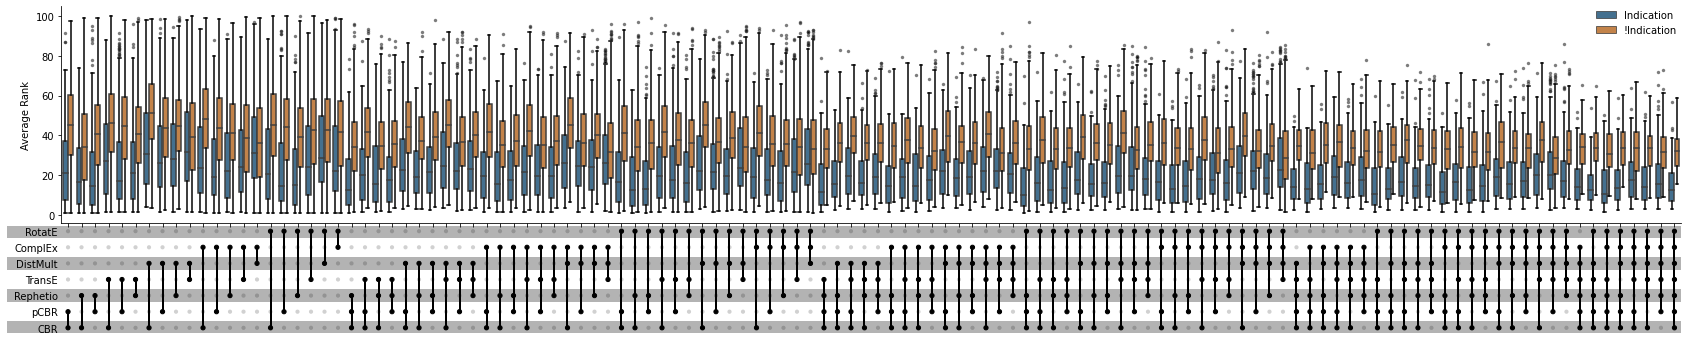

In [52]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 4

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
# ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)


# box plot
sns.boxplot(
    data=mean_rank_df2,
    x="ind",
    y="value",
    hue="variable",
    # color="white",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=2.5, alpha=0.5),
)

ax0.legend(title="", frameon=False, borderaxespad=0)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Average Rank",
)
sns.despine(ax=ax0)

n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in len_algo_rank_dict.items()],
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
# n.plot_totals(ax1_totals)

In [53]:
mean_rank_df2.value = mean_rank_df2.value.astype("float")

/tmp/ipykernel_269031/89816731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_rank_df2.value = mean_rank_df2.value.astype("float")


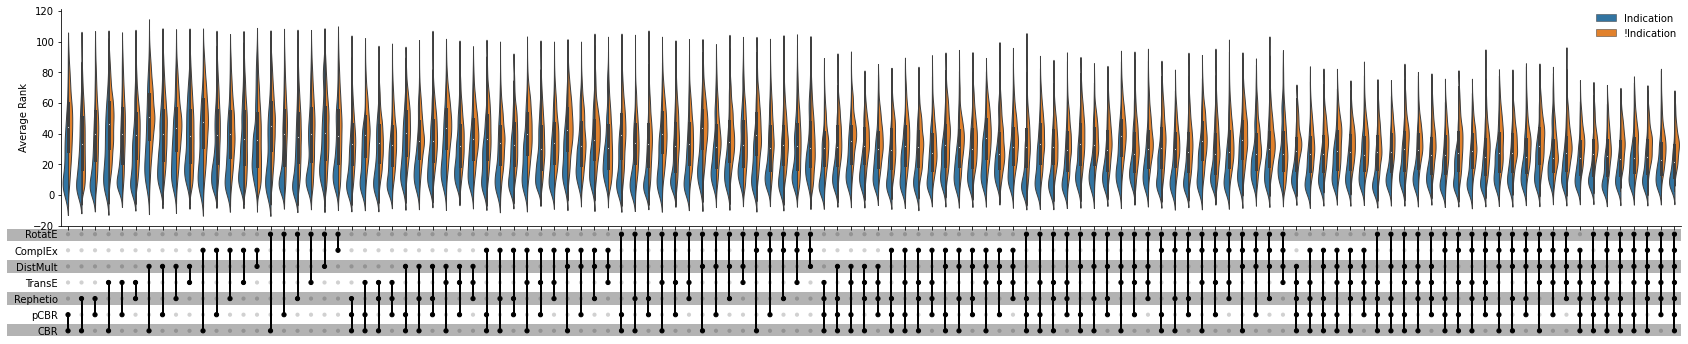

In [54]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 4

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
# ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)


# box plot
sns.violinplot(
    data=mean_rank_df2,
    x="ind",
    y="value",
    hue="variable",
    split=True,
    linewidth=1,
    ax=ax0,
)

ax0.legend(title="", frameon=False, borderaxespad=0)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Average Rank",
)
sns.despine(ax=ax0)

n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in len_algo_rank_dict.items()],
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
# n.plot_totals(ax1_totals)

### Plot RR

In [55]:
# reciprocal rank
rr_df = rank_df[["algos", "rr_ind", "rr_not_ind"]]
rr_df = rr_df.rename(columns={"rr_ind": "Indication", "rr_not_ind": "!Indication"})
rr_df["Indication"] = rr_df.Indication.apply(lambda x: list(x.values()))
rr_df["!Indication"] = rr_df["!Indication"].apply(lambda x: list(x.values()))
rr_df["ind"] = rr_df.algos.apply(lambda x: order_algo_dict[x])
rr_df = rr_df.melt(
    id_vars=["algos", "ind"], value_vars=["Indication", "!Indication"]
).explode("value")
rr_df

,algos,ind,variable,value
0,"(CBR, pCBR)",0,Indication,NaN
1,"(CBR, pCBR)",0,Indication,0.020833
2,"(CBR, pCBR)",0,Indication,0.024884
2,"(CBR, pCBR)",0,Indication,0.505102
3,"(CBR, pCBR)",0,Indication,NaN
...,...,...,...,...
77275,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,NaN
77276,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,NaN
77277,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,NaN
77278,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,NaN


In [56]:
rr_df = rr_df.query("value==value")
rr_df

,algos,ind,variable,value
1,"(CBR, pCBR)",0,Indication,0.020833
2,"(CBR, pCBR)",0,Indication,0.024884
2,"(CBR, pCBR)",0,Indication,0.505102
4,"(CBR, pCBR)",0,Indication,0.516129
5,"(CBR, pCBR)",0,Indication,0.110204
...,...,...,...,...
77257,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,0.193812
77259,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,0.029238
77263,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,0.11622
77263,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,!Indication,0.301634


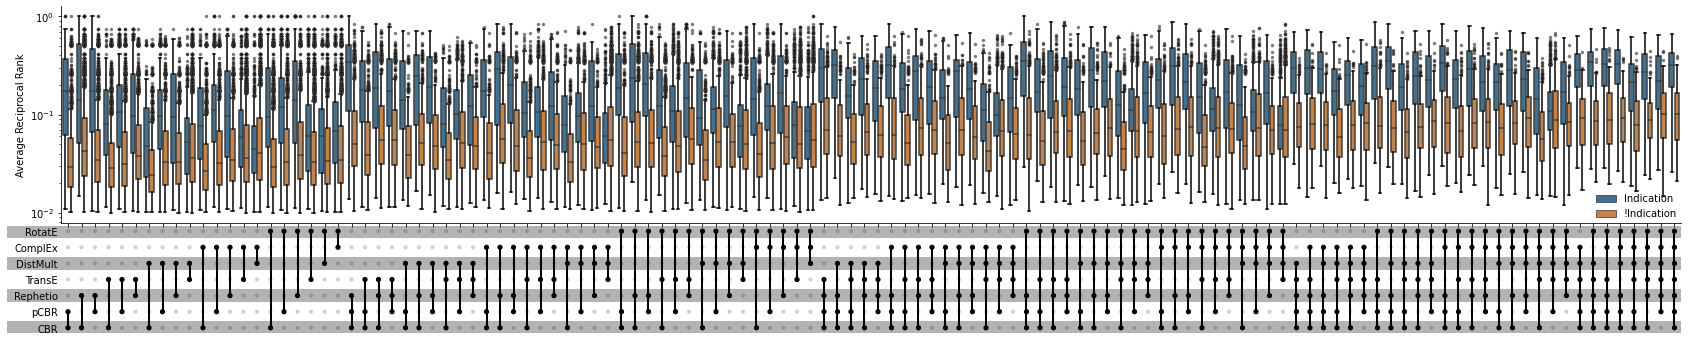

In [57]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 4

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
# ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)


# box plot
sns.boxplot(
    data=rr_df,
    x="ind",
    y="value",
    hue="variable",
    # color="white",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=2.5, alpha=0.5),
)

ax0.legend(title="", frameon=False, borderaxespad=0)

ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Average Reciprocal Rank",
    yscale="log",
)
sns.despine(ax=ax0)

n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in len_algo_rank_dict.items()],
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
# n.plot_totals(ax1_totals)

In [58]:
rr_df.value = rr_df.value.astype("float")

/tmp/ipykernel_269031/136218622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr_df.value = rr_df.value.astype("float")


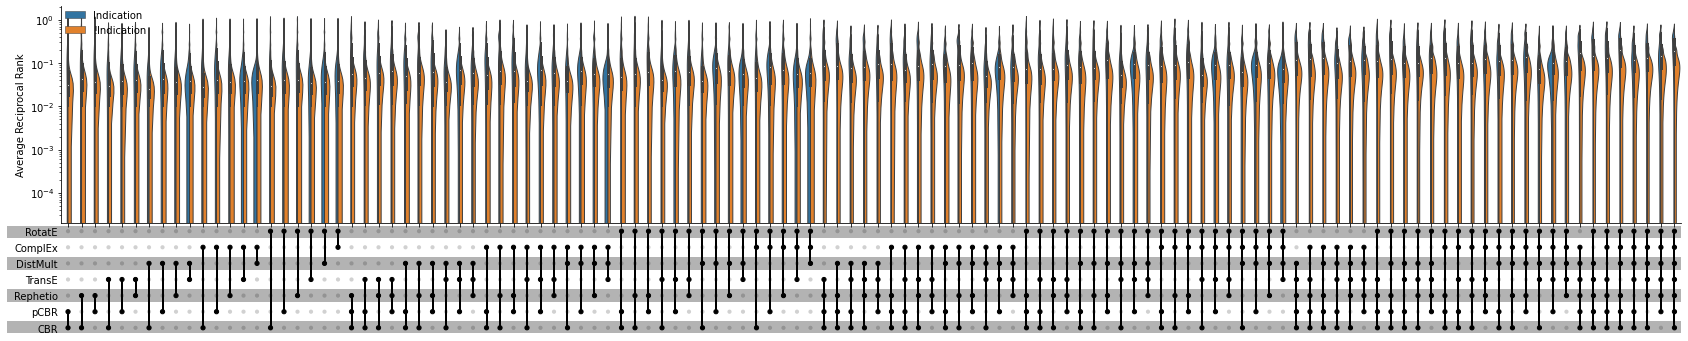

In [59]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 4

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
# ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)


# box plot
sns.violinplot(
    data=rr_df,
    x="ind",
    y="value",
    hue="variable",
    linewidth=1,
    split=True,
    ax=ax0,
)

ax0.legend(title="", frameon=False, borderaxespad=0)

ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Average Reciprocal Rank",
    yscale="log",
)
sns.despine(ax=ax0)

n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in len_algo_rank_dict.items()],
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
# n.plot_totals(ax1_totals)

### Aggregate by number of algorithms "intersection"

In [60]:
mean_rank_df2["algos_len"] = mean_rank_df2.algos.apply(lambda x: float(len(x)))
rr_df["algos_len"] = rr_df.algos.apply(lambda x: float(len(x)))

/tmp/ipykernel_269031/3900393339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_rank_df2["algos_len"] = mean_rank_df2.algos.apply(lambda x: float(len(x)))
/tmp/ipykernel_269031/3900393339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr_df["algos_len"] = rr_df.algos.apply(lambda x: float(len(x)))


In [61]:
mean_rank_df2.head(2)

,algos,ind,variable,value,algos_len
1,"(CBR, pCBR)",0,Indication,49.0,2.0
2,"(CBR, pCBR)",0,Indication,43.0,2.0


In [62]:
rr_df.head(2)

,algos,ind,variable,value,algos_len
1,"(CBR, pCBR)",0,Indication,0.020833,2.0
2,"(CBR, pCBR)",0,Indication,0.024884,2.0


In [63]:
import matplotlib as mpl

In [64]:
mean_rank_df2 = mean_rank_df2.reset_index(drop=True)

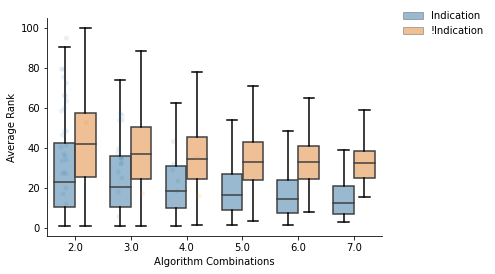

In [65]:
fig, ax = plt.subplots()

sns.boxplot(
    ax=ax,
    data=mean_rank_df2,
    x="algos_len",
    y="value",
    hue="variable",
    saturation=0.75,
    width=0.75,
    showfliers=False,
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
)

# fixes weird alpha when applied to bordering

alpha = 0.5
for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, alpha))

sns.stripplot(
    data=mean_rank_df2.sample(frac=0.00025),
    x="algos_len",
    y="value",
    hue="variable",
    dodge=True,
    ax=ax,
    alpha=0.1,
)

ax.set(
    xlabel="Algorithm Combinations",
    ylabel="Average Rank",
)

sns.despine(ax=ax)

# Get the handles and labels
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(
    handles[0:2], labels[0:2], loc=(1.05, 0.90), frameon=False, borderaxespad=0
)
for lh in legend.legendHandles:
    lh.set_alpha(alpha)

plt.show()

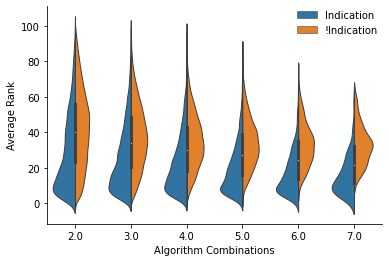

In [66]:
fig, ax = plt.subplots()

sns.violinplot(
    ax=ax,
    data=mean_rank_df2,
    x="algos_len",
    y="value",
    hue="variable",
    linewidth=1,
    split=True,
)
ax.set(
    xlabel="Algorithm Combinations",
    ylabel="Average Rank",
)

sns.despine(ax=ax)
legend = plt.legend(frameon=False, borderaxespad=0)
plt.show()

In [67]:
rr_df = rr_df.reset_index(drop=True)

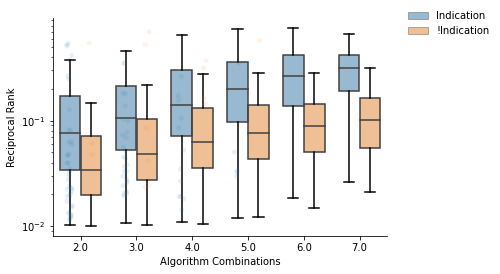

In [68]:
fig, ax = plt.subplots()

sns.boxplot(
    ax=ax,
    data=rr_df,
    x="algos_len",
    y="value",
    hue="variable",
    saturation=0.75,
    width=0.75,
    showfliers=False,
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
)

# fixes weird alpha when applied to bordering
alpha = 0.5
for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, alpha))

sns.stripplot(
    data=rr_df.sample(frac=0.0005),
    x="algos_len",
    y="value",
    hue="variable",
    dodge=True,
    ax=ax,
    alpha=0.1,
)
# log scale y-axis
plt.yscale("log")

# set labels
ax.set(
    xlabel="Algorithm Combinations",
    ylabel="Reciprocal Rank",
)

sns.despine(ax=ax)

# Get the handles and labels
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(
    handles[0:2], labels[0:2], loc=(1.05, 0.90), frameon=False, borderaxespad=0
)
for lh in legend.legendHandles:
    lh.set_alpha(alpha)

plt.show()

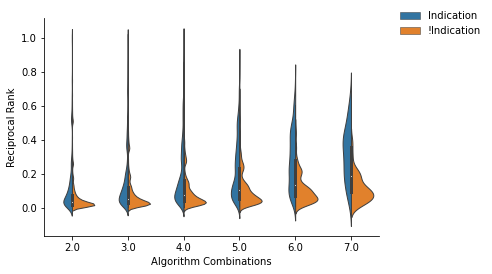

In [69]:
fig, ax = plt.subplots()

sns.violinplot(
    ax=ax, data=rr_df, x="algos_len", y="value", hue="variable", linewidth=1, split=True
)
# set labels
ax.set(
    xlabel="Algorithm Combinations",
    ylabel="Reciprocal Rank",
    # yscale="log"
)

sns.despine(ax=ax)
legend = plt.legend(loc=(1.05, 0.90), frameon=False, borderaxespad=0)
plt.show()

### Reranking results after processing
* probably want to do something like (avg rank -> avg rank),(avg rank -> rr), (rr -> avg rank), (rr -> rr)
* is there even a major ranking difference between the approaches?

In [70]:
# combine avg_ind_rnk and avg_not_ind_rnk
# combine rr_ind and rr_not_ind

rank_rerank_df = rank_df.copy()

In [71]:
print(f"Number of indications in postion 1: {len(rank_rerank_df.avg_ind_rnk.iloc[0])}")
print(
    f"Number of not indications in position 1: {len(rank_rerank_df.avg_not_ind_rnk.iloc[0])}"
)

Number of indications in postion 1: 0
Number of not indications in position 1: 2


In [72]:
rank_rerank_df.avg_ind_rnk.iloc[0]

{}

In [73]:
"DOID:7148" in rank_rerank_df.avg_not_ind_rnk.iloc[0].keys()

False

In [74]:
rank_rerank_df["avg_rnk"] = [
    dict(sorted(j.items(), key=lambda x: x[1]))
    for j in [
        {**dicts, **list(rank_rerank_df.avg_ind_rnk)[i]}
        for i, dicts in enumerate(list(rank_rerank_df.avg_not_ind_rnk))
    ]
]

In [75]:
len(rank_rerank_df.avg_rnk.iloc[0])

2

In [76]:
rank_rerank_df = rank_rerank_df[
    ["algos", "compounds", "true_t", "avg_rnk", "rr_ind", "rr_not_ind"]
]
rank_rerank_df

,algos,compounds,true_t,avg_rnk,rr_ind,rr_not_ind
0,"(CBR, pCBR)",CHEBI:3023,[DOID:13189],"{'DOID:0050700': 52.5, 'DOID:12849': 61.0}",{},"{'DOID:0050700': 0.026250000000000002, 'DOID:1..."
1,"(CBR, pCBR)",CHEBI:567361,"[DOID:6354, DOID:0050784, DOID:1039, DOID:2378...","{'DOID:10283': 4.5, 'DOID:2841': 20.0, 'DOID:2...",{'MESH:D002471': 0.020833333333333332},"{'DOID:2841': 0.09803921568627451, 'DOID:7148'..."
2,"(CBR, pCBR)",CHEBI:9334,"[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85...","{'DOID:2394': 24.0, 'DOID:10763': 30.0, 'DOID:...","{'DOID:7148': 0.02488425925925926, 'DOID:8577'...","{'DOID:11054': 0.02395833333333333, 'DOID:4450..."
3,"(CBR, pCBR)",CHEBI:3216,"[DOID:2559, DOID:11206]","{'DOID:10283': 3.5, 'DOID:10763': 24.5, 'DOID:...",{},"{'DOID:2841': 0.019960474308300395, 'DOID:1826..."
4,"(CBR, pCBR)",CHEBI:5801,"[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303...","{'DOID:7148': 16.0, 'DOID:8577': 40.0, 'DOID:3...",{'DOID:7148': 0.5161290322580645},"{'DOID:3770': 0.013038548752834465, 'DOID:8577..."
...,...,...,...,...,...,...
38635,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:32087,[DOID:4481],{},{},{}
38636,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:28445,"[DOID:6354, DOID:0050873, DOID:706, DOID:1037,...",{},{},{}
38637,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:15854,"[DOID:14325, DOID:14068, DOID:12978, DOID:1432...",{},{},{}
38638,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:61030,[DOID:893],{},{},{}


In [77]:
rank_rerank_df["rr_rnk"] = [
    dict(sorted(j.items(), key=lambda x: x[1], reverse=True))
    for j in [
        {**dicts, **list(rank_rerank_df.rr_ind)[i]}
        for i, dicts in enumerate(list(rank_rerank_df.rr_not_ind))
    ]
]

In [78]:
print(f"Number of indications in postion 1: {len(rank_rerank_df.rr_ind.iloc[0])}")
print(
    f"Number of not indications in position 1: {len(rank_rerank_df.rr_not_ind.iloc[0])}"
)
print(
    f"Number of total predictions in position 1: {len(rank_rerank_df.rr_rnk.iloc[0])}"
)

Number of indications in postion 1: 0
Number of not indications in position 1: 2
Number of total predictions in position 1: 2


In [79]:
rank_rerank_df = rank_rerank_df[["algos", "compounds", "true_t", "avg_rnk", "rr_rnk"]]
rank_rerank_df.head()

,algos,compounds,true_t,avg_rnk,rr_rnk
0,"(CBR, pCBR)",CHEBI:3023,[DOID:13189],"{'DOID:0050700': 52.5, 'DOID:12849': 61.0}","{'DOID:0050700': 0.026250000000000002, 'DOID:1..."
1,"(CBR, pCBR)",CHEBI:567361,"[DOID:6354, DOID:0050784, DOID:1039, DOID:2378...","{'DOID:10283': 4.5, 'DOID:2841': 20.0, 'DOID:2...","{'DOID:10283': 0.3214285714285714, 'DOID:2355'..."
2,"(CBR, pCBR)",CHEBI:9334,"[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85...","{'DOID:2394': 24.0, 'DOID:10763': 30.0, 'DOID:...","{'DOID:8577': 0.5051020408163265, 'DOID:2394':..."
3,"(CBR, pCBR)",CHEBI:3216,"[DOID:2559, DOID:11206]","{'DOID:10283': 3.5, 'DOID:10763': 24.5, 'DOID:...","{'DOID:10283': 0.5833333333333334, 'DOID:10763..."
4,"(CBR, pCBR)",CHEBI:5801,"[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303...","{'DOID:7148': 16.0, 'DOID:8577': 40.0, 'DOID:3...","{'DOID:7148': 0.5161290322580645, 'DOID:8577':..."


In [80]:
rank_rerank_df.avg_rnk.iloc[0].values()

dict_values([52.5, 61.0])

In [81]:
reg_avg_rnk = list()

for dicts in list(rank_rerank_df.avg_rnk):
    store_dict = dict()
    rnk_val = 1
    for i, (k, v) in enumerate(dicts.items()):
        if i != 0 and list(dicts.values())[i - 1] == v:
            store_dict.update({k: rnk_val})
        else:
            store_dict.update({k: rnk_val})
            rnk_val += 1

    reg_avg_rnk.append(store_dict)

In [82]:
reg_rr_rnk = list()

for dicts in list(rank_rerank_df.rr_rnk):
    store_dict = dict()
    rnk_val = 1
    for i, (k, v) in enumerate(dicts.items()):
        if i != 0 and list(dicts.values())[i - 1] == v:
            store_dict.update({k: rnk_val})
        else:
            store_dict.update({k: rnk_val})
            rnk_val += 1

    reg_rr_rnk.append(store_dict)

In [83]:
rank_rerank_df["reranked_avg_rnk"] = reg_avg_rnk
rank_rerank_df["reranked_rr_rnk"] = reg_rr_rnk

/tmp/ipykernel_269031/3511442367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_rerank_df["reranked_avg_rnk"] = reg_avg_rnk


In [84]:
rank_rerank_df.head()

,algos,compounds,true_t,avg_rnk,rr_rnk,reranked_avg_rnk,reranked_rr_rnk
0,"(CBR, pCBR)",CHEBI:3023,[DOID:13189],"{'DOID:0050700': 52.5, 'DOID:12849': 61.0}","{'DOID:0050700': 0.026250000000000002, 'DOID:1...","{'DOID:0050700': 1, 'DOID:12849': 2}","{'DOID:0050700': 1, 'DOID:12849': 2}"
1,"(CBR, pCBR)",CHEBI:567361,"[DOID:6354, DOID:0050784, DOID:1039, DOID:2378...","{'DOID:10283': 4.5, 'DOID:2841': 20.0, 'DOID:2...","{'DOID:10283': 0.3214285714285714, 'DOID:2355'...","{'DOID:10283': 1, 'DOID:2841': 2, 'DOID:2394':...","{'DOID:10283': 1, 'DOID:2355': 2, 'DOID:2394':..."
2,"(CBR, pCBR)",CHEBI:9334,"[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85...","{'DOID:2394': 24.0, 'DOID:10763': 30.0, 'DOID:...","{'DOID:8577': 0.5051020408163265, 'DOID:2394':...","{'DOID:2394': 1, 'DOID:10763': 2, 'DOID:3770':...","{'DOID:8577': 1, 'DOID:2394': 2, 'DOID:3770': ..."
3,"(CBR, pCBR)",CHEBI:3216,"[DOID:2559, DOID:11206]","{'DOID:10283': 3.5, 'DOID:10763': 24.5, 'DOID:...","{'DOID:10283': 0.5833333333333334, 'DOID:10763...","{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:1826'...","{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:12849..."
4,"(CBR, pCBR)",CHEBI:5801,"[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303...","{'DOID:7148': 16.0, 'DOID:8577': 40.0, 'DOID:3...","{'DOID:7148': 0.5161290322580645, 'DOID:8577':...","{'DOID:7148': 1, 'DOID:8577': 2, 'DOID:3770': 3}","{'DOID:7148': 1, 'DOID:8577': 2, 'DOID:3770': 3}"


In [85]:
rank_rerank_df = rank_rerank_df[
    ["algos", "compounds", "true_t", "reranked_avg_rnk", "reranked_rr_rnk"]
]

In [86]:
# dataframe of averaging, reranking
avg_rank_rerank_df = rank_rerank_df[
    ["algos", "compounds", "true_t", "reranked_avg_rnk"]
]
# dataframe of reciprocal ranking, reranking
rr_rank_rerank_df = rank_rerank_df[["algos", "compounds", "true_t", "reranked_rr_rnk"]]

In [87]:
def extract_inds(inds_ls: list, rnks: dict) -> dict:
    """
    Given a list of known indications, extract the rank of the indications, and the rank of the non-indications and return them as a dict
    If it doesn't exist, skip it.
    """
    inds_dict = dict()
    for inds in inds_ls:
        try:
            v = rnks[inds]
            inds_dict.update({inds: v})
        except:
            next

    not_inds_dict = {k: v for k, v in rnks.items() if k not in inds_ls}

    return inds_dict, not_inds_dict

In [88]:
tmp_res = [
    extract_inds(inds_ls=list(avg_rank_rerank_df.true_t)[i], rnks=rnks)
    for i, rnks in enumerate(list(avg_rank_rerank_df.reranked_avg_rnk))
]

In [89]:
avg_rank_rerank_df["ind_reranked_avg_rnk"] = [ind for ind, not_ind in tmp_res]
avg_rank_rerank_df["not_ind_rereanked_avg_rnk"] = [not_ind for ind, not_ind in tmp_res]

In [90]:
tmp_res = [
    extract_inds(inds_ls=list(rr_rank_rerank_df.true_t)[i], rnks=rnks)
    for i, rnks in enumerate(list(rr_rank_rerank_df.reranked_rr_rnk))
]

In [91]:
rr_rank_rerank_df["ind_reranked_rr_rnk"] = [ind for ind, not_ind in tmp_res]
rr_rank_rerank_df["not_ind_reranked_rr_rnk"] = [not_ind for ind, not_ind in tmp_res]

In [92]:
avg_rank_rerank_df.head()

,algos,compounds,true_t,reranked_avg_rnk,ind_reranked_avg_rnk,not_ind_rereanked_avg_rnk
0,"(CBR, pCBR)",CHEBI:3023,[DOID:13189],"{'DOID:0050700': 1, 'DOID:12849': 2}",{},"{'DOID:0050700': 1, 'DOID:12849': 2}"
1,"(CBR, pCBR)",CHEBI:567361,"[DOID:6354, DOID:0050784, DOID:1039, DOID:2378...","{'DOID:10283': 1, 'DOID:2841': 2, 'DOID:2394':...",{'MESH:D002471': 6},"{'DOID:10283': 1, 'DOID:2841': 2, 'DOID:2394':..."
2,"(CBR, pCBR)",CHEBI:9334,"[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85...","{'DOID:2394': 1, 'DOID:10763': 2, 'DOID:3770':...","{'DOID:7148': 6, 'DOID:8577': 11}","{'DOID:2394': 1, 'DOID:10763': 2, 'DOID:3770':..."
3,"(CBR, pCBR)",CHEBI:3216,"[DOID:2559, DOID:11206]","{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:1826'...",{},"{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:1826'..."
4,"(CBR, pCBR)",CHEBI:5801,"[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303...","{'DOID:7148': 1, 'DOID:8577': 2, 'DOID:3770': 3}",{'DOID:7148': 1},"{'DOID:8577': 2, 'DOID:3770': 3}"


In [93]:
rr_rank_rerank_df.head()

,algos,compounds,true_t,reranked_rr_rnk,ind_reranked_rr_rnk,not_ind_reranked_rr_rnk
0,"(CBR, pCBR)",CHEBI:3023,[DOID:13189],"{'DOID:0050700': 1, 'DOID:12849': 2}",{},"{'DOID:0050700': 1, 'DOID:12849': 2}"
1,"(CBR, pCBR)",CHEBI:567361,"[DOID:6354, DOID:0050784, DOID:1039, DOID:2378...","{'DOID:10283': 1, 'DOID:2355': 2, 'DOID:2394':...",{'MESH:D002471': 9},"{'DOID:10283': 1, 'DOID:2355': 2, 'DOID:2394':..."
2,"(CBR, pCBR)",CHEBI:9334,"[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85...","{'DOID:8577': 1, 'DOID:2394': 2, 'DOID:3770': ...","{'DOID:7148': 11, 'DOID:8577': 1}","{'DOID:2394': 2, 'DOID:3770': 3, 'DOID:10283':..."
3,"(CBR, pCBR)",CHEBI:3216,"[DOID:2559, DOID:11206]","{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:12849...",{},"{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:12849..."
4,"(CBR, pCBR)",CHEBI:5801,"[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303...","{'DOID:7148': 1, 'DOID:8577': 2, 'DOID:3770': 3}",{'DOID:7148': 1},"{'DOID:8577': 2, 'DOID:3770': 3}"


### Extract values and plot

In [94]:
avg_rank_rerank_df = avg_rank_rerank_df[
    ["algos", "compounds", "ind_reranked_avg_rnk", "not_ind_rereanked_avg_rnk"]
]
rr_rank_rerank_df = rr_rank_rerank_df[
    ["algos", "compounds", "ind_reranked_rr_rnk", "not_ind_reranked_rr_rnk"]
]

In [95]:
avg_rank_rerank_df = avg_rank_rerank_df.rename(
    columns={
        "ind_reranked_avg_rnk": "Indication",
        "not_ind_rereanked_avg_rnk": "!Indication",
    }
)
avg_rank_rerank_df["Indication"] = avg_rank_rerank_df.Indication.apply(
    lambda x: list(x.items())
)
avg_rank_rerank_df["!Indication"] = avg_rank_rerank_df["!Indication"].apply(
    lambda x: list(x.items())
)
avg_rank_rerank_df["ind"] = avg_rank_rerank_df.algos.apply(lambda x: order_algo_dict[x])
avg_rank_rerank_df = avg_rank_rerank_df.melt(
    id_vars=["algos", "ind", "compounds"], value_vars=["Indication", "!Indication"]
).explode("value")

In [96]:
avg_rank_rerank_df = avg_rank_rerank_df.dropna()
avg_rank_rerank_df.head()

,algos,ind,compounds,variable,value
1,"(CBR, pCBR)",0,CHEBI:567361,Indication,"(MESH:D002471, 6)"
2,"(CBR, pCBR)",0,CHEBI:9334,Indication,"(DOID:7148, 6)"
2,"(CBR, pCBR)",0,CHEBI:9334,Indication,"(DOID:8577, 11)"
4,"(CBR, pCBR)",0,CHEBI:5801,Indication,"(DOID:7148, 1)"
5,"(CBR, pCBR)",0,CHEBI:31236,Indication,"(DOID:3312, 2)"


In [97]:
avg_rank_rerank_df.shape

(196750, 5)

In [98]:
avg_rank_rerank_df["disease"] = avg_rank_rerank_df.value.apply(lambda x: x[0])
avg_rank_rerank_df["value"] = avg_rank_rerank_df.value.apply(lambda x: x[1])
avg_rank_rerank_df.head()

,algos,ind,compounds,variable,value,disease
1,"(CBR, pCBR)",0,CHEBI:567361,Indication,6,MESH:D002471
2,"(CBR, pCBR)",0,CHEBI:9334,Indication,6,DOID:7148
2,"(CBR, pCBR)",0,CHEBI:9334,Indication,11,DOID:8577
4,"(CBR, pCBR)",0,CHEBI:5801,Indication,1,DOID:7148
5,"(CBR, pCBR)",0,CHEBI:31236,Indication,2,DOID:3312


In [99]:
rr_rank_rerank_df = rr_rank_rerank_df.rename(
    columns={
        "ind_reranked_rr_rnk": "Indication",
        "not_ind_reranked_rr_rnk": "!Indication",
    }
)
rr_rank_rerank_df["Indication"] = rr_rank_rerank_df.Indication.apply(
    lambda x: list(x.items())
)
rr_rank_rerank_df["!Indication"] = rr_rank_rerank_df["!Indication"].apply(
    lambda x: list(x.items())
)
rr_rank_rerank_df["ind"] = rr_rank_rerank_df.algos.apply(lambda x: order_algo_dict[x])
rr_rank_rerank_df = rr_rank_rerank_df.melt(
    id_vars=["algos", "ind", "compounds"], value_vars=["Indication", "!Indication"]
).explode("value")

rr_rank_rerank_df = rr_rank_rerank_df.dropna()
rr_rank_rerank_df["disease"] = rr_rank_rerank_df.value.apply(lambda x: x[0])
rr_rank_rerank_df["value"] = rr_rank_rerank_df.value.apply(lambda x: x[1])
rr_rank_rerank_df.head()

,algos,ind,compounds,variable,value,disease
1,"(CBR, pCBR)",0,CHEBI:567361,Indication,9,MESH:D002471
2,"(CBR, pCBR)",0,CHEBI:9334,Indication,11,DOID:7148
2,"(CBR, pCBR)",0,CHEBI:9334,Indication,1,DOID:8577
4,"(CBR, pCBR)",0,CHEBI:5801,Indication,1,DOID:7148
5,"(CBR, pCBR)",0,CHEBI:31236,Indication,4,DOID:3312


In [100]:
rr_rank_rerank_df.shape

(196750, 6)

### Plot rerank after averaging

In [101]:
avg_rank_rerank_df.value = avg_rank_rerank_df.value.astype("float")

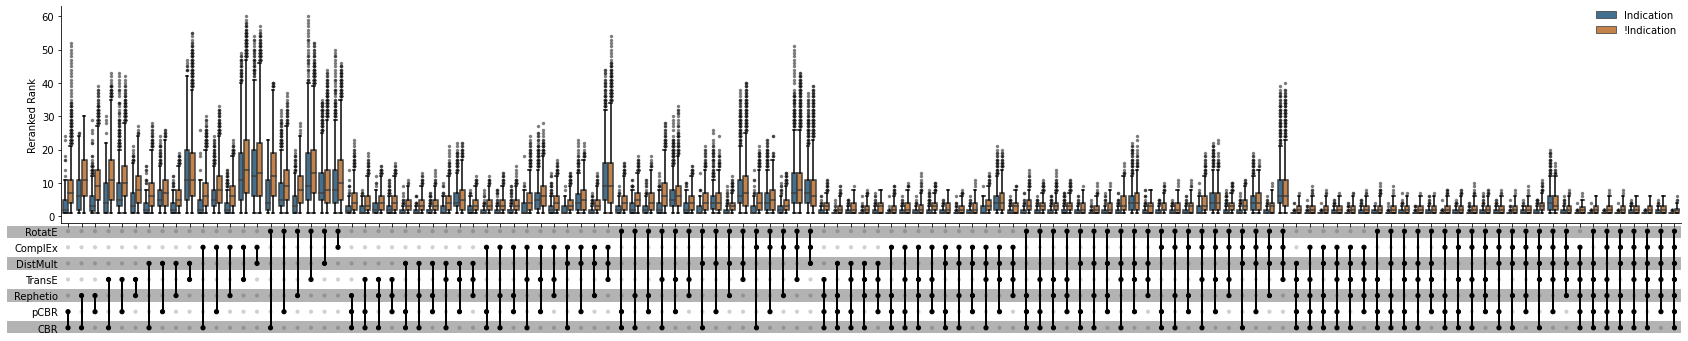

In [102]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 4

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
# ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)


# box plot
sns.boxplot(
    data=avg_rank_rerank_df,
    x="ind",
    y="value",
    hue="variable",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=2.5, alpha=0.5),
)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Reranked Rank",
)

ax0.legend(title="", frameon=False, borderaxespad=0)

sns.despine(ax=ax0)

n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in len_algo_rank_dict.items()],
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
# n.plot_totals(ax1_totals)

In [103]:
avg_rank_rerank_df.value = avg_rank_rerank_df.value.astype("float")

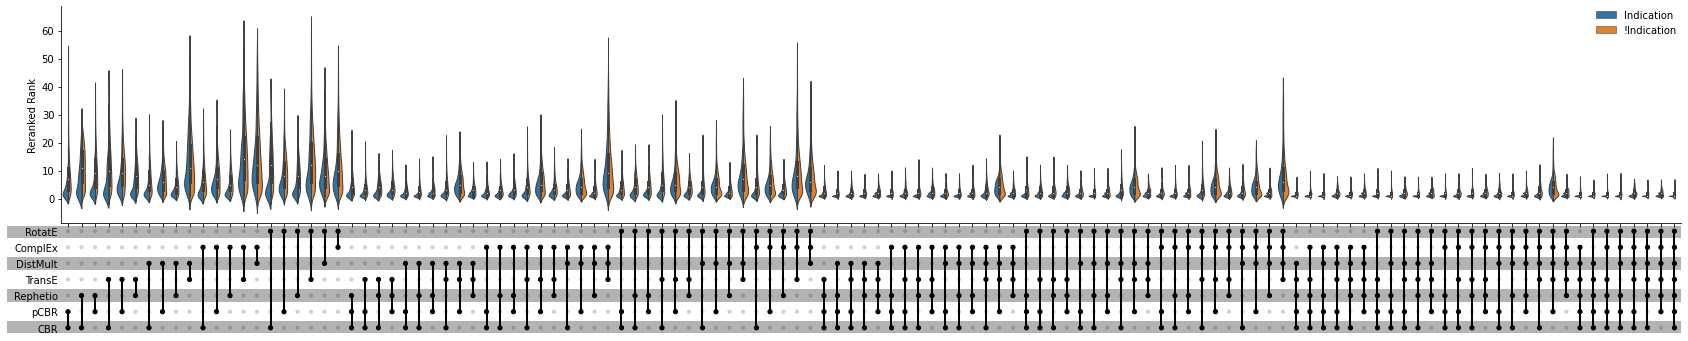

In [104]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 4

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
# ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)


# box plot
sns.violinplot(
    data=avg_rank_rerank_df,
    x="ind",
    y="value",
    hue="variable",
    ax=ax0,
    split=True,
    linewidth=1,
)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Reranked Rank",
)

ax0.legend(title="", frameon=False, borderaxespad=0)

sns.despine(ax=ax0)

n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in len_algo_rank_dict.items()],
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
# n.plot_totals(ax1_totals)

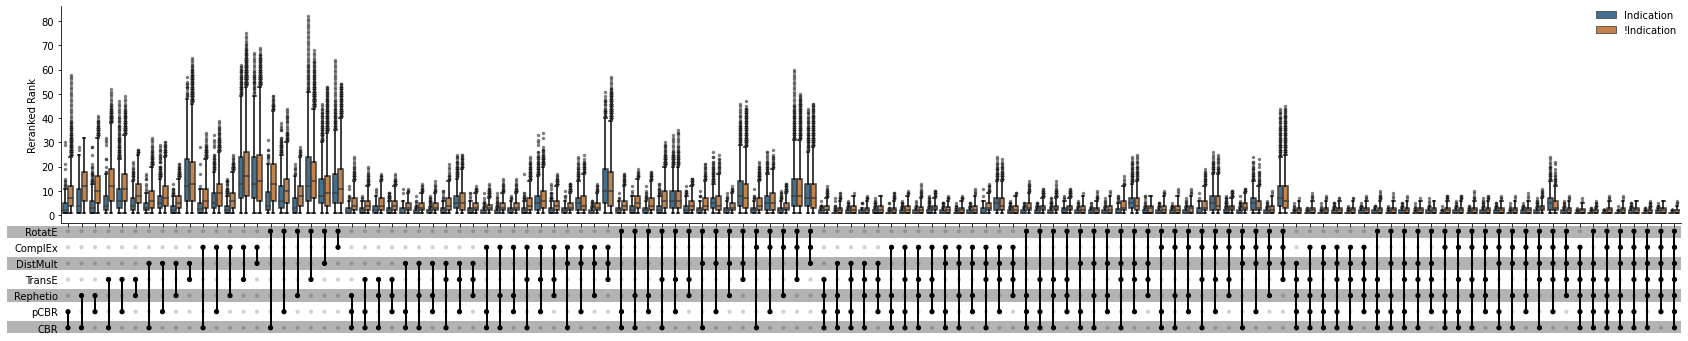

In [105]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 4

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)

# box plot
sns.boxplot(
    data=rr_rank_rerank_df,
    x="ind",
    y="value",
    hue="variable",
    # color="white",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    # medianprops=dict(color="black"),
    # boxprops=dict(facecolor="none", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=2.5, alpha=0.5),
)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Reranked Rank",
)
ax0.legend(title="", frameon=False, borderaxespad=0)

sns.despine(ax=ax0)

n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in len_algo_rank_dict.items()],
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
# n.plot_totals(ax1_totals)

In [106]:
rr_rank_rerank_df.value = rr_rank_rerank_df.value.astype("float")

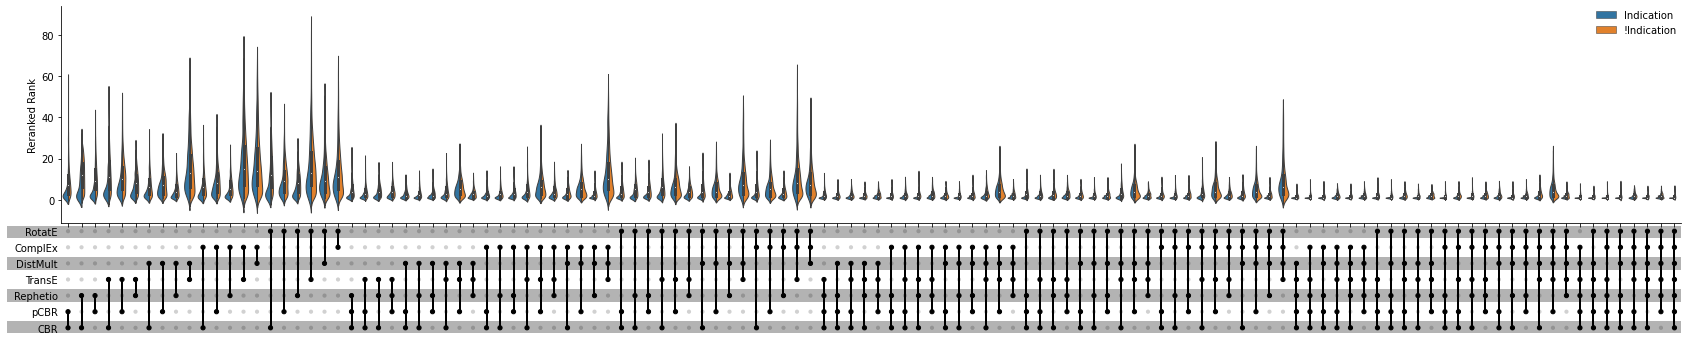

In [107]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 4

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)

# box plot
sns.violinplot(
    data=rr_rank_rerank_df,
    x="ind",
    y="value",
    hue="variable",
    split=True,
    linewidth=1,
    ax=ax0,
)
ax0.set(
    xticklabels=[],
    xlabel="",
    ylabel="Reranked Rank",
)
ax0.legend(title="", frameon=False, borderaxespad=0)

sns.despine(ax=ax0)

n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in len_algo_rank_dict.items()],
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)

### Aggregate results by number of combos... again

In [108]:
avg_rank_rerank_df["algos_len"] = avg_rank_rerank_df.algos.apply(
    lambda x: float(len(x))
)
rr_rank_rerank_df["algos_len"] = rr_rank_rerank_df.algos.apply(lambda x: float(len(x)))

In [109]:
avg_rank_rerank_df = avg_rank_rerank_df.reset_index(drop=True)
rr_rank_rerank_df = rr_rank_rerank_df.reset_index(drop=True)

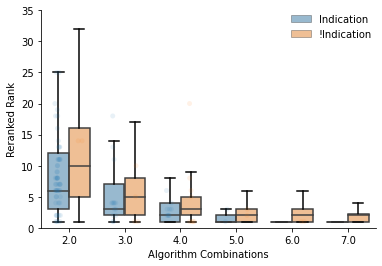

In [110]:
fig, ax = plt.subplots()

sns.boxplot(
    ax=ax,
    data=avg_rank_rerank_df,
    x="algos_len",
    y="value",
    hue="variable",
    # color="white",
    saturation=0.75,
    width=0.75,
    showfliers=False,
    # medianprops=dict(color="black"),
    # boxprops=dict(alpha = 0.3),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    # flierprops=dict(marker="o", markerfacecolor="black", markersize=2.5, alpha = 0.5),
)

# fixes weird alpha when applied to bordering
alpha = 0.5
for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, alpha))

sns.stripplot(
    data=avg_rank_rerank_df.sample(frac=0.0005),
    x="algos_len",
    y="value",
    hue="variable",
    dodge=True,
    ax=ax,
    alpha=0.1,
)
# log scale y-axis
# plt.yscale("log")

# set labels
ax.set(xlabel="Algorithm Combinations", ylabel="Reranked Rank", ylim=[0, 35])

sns.despine(ax=ax)

# Get the handles and labels
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles[0:2], labels[0:2], frameon=False, borderaxespad=0)
for lh in legend.legendHandles:
    lh.set_alpha(alpha)

plt.show()

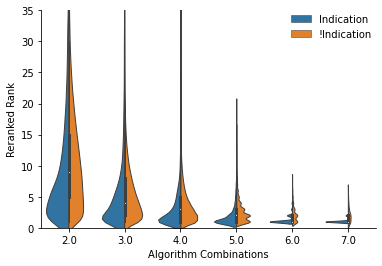

In [111]:
fig, ax = plt.subplots()

sns.violinplot(
    ax=ax,
    data=avg_rank_rerank_df,
    x="algos_len",
    y="value",
    hue="variable",
    split=True,
    linewidth=1,
)

# set labels
ax.set(xlabel="Algorithm Combinations", ylabel="Reranked Rank", ylim=[0, 35])

sns.despine(ax=ax)
legend = plt.legend(frameon=False, borderaxespad=0)

plt.show()

In [112]:
avg_rank_rerank_df["reciprocal_val"] = avg_rank_rerank_df["value"].apply(
    lambda x: 1 / x
)

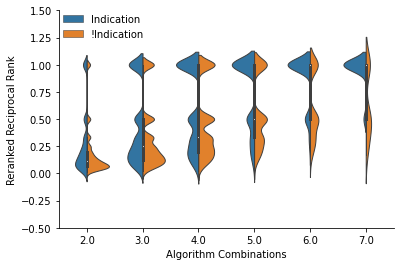

In [113]:
fig, ax = plt.subplots()

sns.violinplot(
    ax=ax,
    data=avg_rank_rerank_df,
    x="algos_len",
    y="reciprocal_val",
    hue="variable",
    split=True,
    linewidth=1,
)

# set labels
ax.set(
    xlabel="Algorithm Combinations", ylabel="Reranked Reciprocal Rank", ylim=[-0.5, 1.5]
)

sns.despine(ax=ax)
legend = plt.legend(loc="upper left", frameon=False, borderaxespad=0)

plt.show()

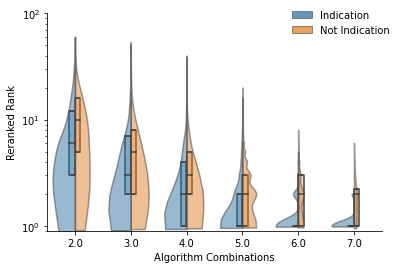

In [115]:
fig, ax = plt.subplots()

sns.boxplot(
    ax=ax,
    data=avg_rank_rerank_df,
    x="algos_len",
    y="value",
    hue="variable",
    saturation=0.75,
    width=0.20,
    showfliers=False,
    whis=0
    # whiskerprops=dict(color="black"),
    # capprops=dict(color="black"),
)

# fixes weird alpha when applied to bordering
alpha = 0.25
for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, alpha))

sns.violinplot(
    ax=ax,
    data=avg_rank_rerank_df,
    x="algos_len",
    y="value",
    hue="variable",
    split=True,
    inner=None,
    cut=0.1,
    saturation=0.75,
)

for violin in ax.collections:
    violin.set_alpha(0.5)

# set labels
ax.set(
    xlabel="Algorithm Combinations",
    ylabel="Reranked Rank",
    ylim=[0.90, 100],
    yscale="log",
)

sns.despine(ax=ax)

# Get the handles and labels
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(
#    handles[0:2], labels[0:2], loc=(0.72, 0.88), frameon=False, borderaxespad=0
    handles[0:2], ['Indication','Not Indication'], loc=(0.72, 0.88), frameon=False, borderaxespad=0
)
for lh in legend.legendHandles:
    lh.set_alpha(0.75)

plt.savefig(
    "boxviolin_collapsed_intersection_avg_rerank.png", dpi=400, bbox_inches="tight"
)
plt.show()

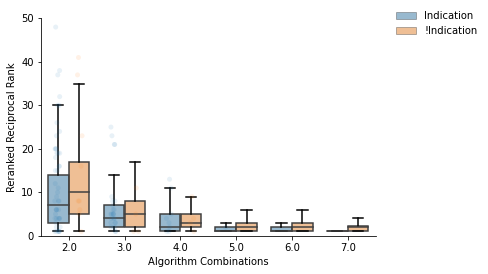

In [116]:
fig, ax = plt.subplots()

sns.boxplot(
    ax=ax,
    data=rr_rank_rerank_df,
    x="algos_len",
    y="value",
    hue="variable",
    # color="white",
    saturation=0.75,
    width=0.75,
    showfliers=False,
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
)

# fixes weird alpha when applied to bordering
alpha = 0.5
for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, alpha))

sns.stripplot(
    data=rr_rank_rerank_df.sample(frac=0.0005),
    x="algos_len",
    y="value",
    hue="variable",
    dodge=True,
    ax=ax,
    alpha=0.1,
)
# set labels
ax.set(xlabel="Algorithm Combinations", ylabel="Reranked Reciprocal Rank", ylim=[0, 50])

sns.despine(ax=ax)

# Get the handles and labels
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(
    handles[0:2], labels[0:2], loc=(1.05, 0.90), frameon=False, borderaxespad=0
)
for lh in legend.legendHandles:
    lh.set_alpha(alpha)

plt.show()

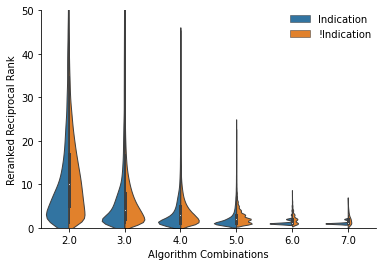

In [117]:
fig, ax = plt.subplots()

sns.violinplot(
    ax=ax,
    data=rr_rank_rerank_df,
    x="algos_len",
    y="value",
    hue="variable",
    split=True,
    linewidth=1,
)

ax.set(xlabel="Algorithm Combinations", ylabel="Reranked Reciprocal Rank", ylim=[0, 50])

sns.despine(ax=ax)
legend = plt.legend(frameon=False, borderaxespad=0)

plt.show()

In [118]:
rr_rank_rerank_df["reciprocal_val"] = rr_rank_rerank_df["value"].apply(lambda x: 1 / x)

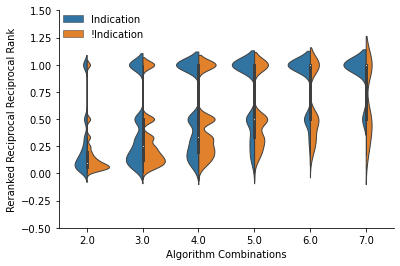

In [119]:
fig, ax = plt.subplots()

sns.violinplot(
    ax=ax,
    data=rr_rank_rerank_df,
    x="algos_len",
    y="reciprocal_val",
    hue="variable",
    split=True,
    linewidth=1,
)

ax.set(
    xlabel="Algorithm Combinations",
    ylabel="Reranked Reciprocal Reciprocal Rank",
    ylim=[-0.5, 1.5],
)

sns.despine(ax=ax)
legend = plt.legend(loc="upper left", frameon=False, borderaxespad=0)

plt.show()

## Run some stats on the intersection
* Kruskal-Wallace to identify differences in mean
* Check for shifts in distributions for non-parametric distributions using Mann-Whitney

In [120]:
import scipy

In [121]:
# Results suggest that at least one median is statistically different from the other (intra-Indication set)
scipy.stats.kruskal(
    avg_rank_rerank_df.query('algos_len==2 & variable=="Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==3 & variable=="Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==4 & variable=="Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==5 & variable=="Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==6 & variable=="Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==7 & variable=="Indication"').dropna().value,
)

KruskalResult(statistic=7614.539232006504, pvalue=0.0)

In [122]:
# Results suggest that at least one median is statistically different from the other (intra-NOT Indication set)
scipy.stats.kruskal(
    avg_rank_rerank_df.query('algos_len==2 & variable=="!Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==3 & variable=="!Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==4 & variable=="!Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==5 & variable=="!Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==6 & variable=="!Indication"').dropna().value,
    avg_rank_rerank_df.query('algos_len==7 & variable=="!Indication"').dropna().value,
)

KruskalResult(statistic=33283.655606097, pvalue=0.0)

In [123]:
# Results suggest that at least one median is statistically different from the other (Both Indication and NOT Indication set)
# really no need to test this because above has differences.
scipy.stats.kruskal(
    avg_rank_rerank_df.query("algos_len==2").dropna().value,
    avg_rank_rerank_df.query("algos_len==3").dropna().value,
    avg_rank_rerank_df.query("algos_len==4").dropna().value,
    avg_rank_rerank_df.query("algos_len==5").dropna().value,
    avg_rank_rerank_df.query("algos_len==6").dropna().value,
    avg_rank_rerank_df.query("algos_len==7").dropna().value,
)

KruskalResult(statistic=44951.160393921404, pvalue=0.0)

### Mann-Whitney U-Test between Indication and Non-Indication

In [124]:
scipy.stats.mannwhitneyu(
    x=avg_rank_rerank_df.query('variable=="Indication"').dropna().value,
    y=avg_rank_rerank_df.query('variable=="!Indication"').dropna().value,
)

MannwhitneyuResult(statistic=2081829972.0, pvalue=0.0)

#### Mann-Whitney Test based on algo size

In [125]:
scipy.stats.mannwhitneyu(
    x=avg_rank_rerank_df.query('variable=="Indication" & algos_len==2').dropna().value,
    y=avg_rank_rerank_df.query('variable=="!Indication" & algos_len==2').dropna().value,
)

MannwhitneyuResult(statistic=452774469.5, pvalue=0.0)

In [126]:
scipy.stats.mannwhitneyu(
    x=avg_rank_rerank_df.query('variable=="Indication" & algos_len==3').dropna().value,
    y=avg_rank_rerank_df.query('variable=="!Indication" & algos_len==3').dropna().value,
)

MannwhitneyuResult(statistic=243123284.5, pvalue=3.6984658194930937e-166)

In [127]:
scipy.stats.mannwhitneyu(
    x=avg_rank_rerank_df.query('variable=="Indication" & algos_len==4').dropna().value,
    y=avg_rank_rerank_df.query('variable=="!Indication" & algos_len==4').dropna().value,
)

MannwhitneyuResult(statistic=57061396.0, pvalue=2.8690060593780063e-127)

In [128]:
scipy.stats.mannwhitneyu(
    x=avg_rank_rerank_df.query('variable=="Indication" & algos_len==5').dropna().value,
    y=avg_rank_rerank_df.query('variable=="!Indication" & algos_len==5').dropna().value,
)

MannwhitneyuResult(statistic=5264072.0, pvalue=2.836769337936229e-123)

In [129]:
scipy.stats.mannwhitneyu(
    x=avg_rank_rerank_df.query('variable=="Indication" & algos_len==6').dropna().value,
    y=avg_rank_rerank_df.query('variable=="!Indication" & algos_len==6').dropna().value,
)

MannwhitneyuResult(statistic=164614.0, pvalue=7.683710816792981e-69)

In [130]:
scipy.stats.mannwhitneyu(
    x=avg_rank_rerank_df.query('variable=="Indication" & algos_len==7').dropna().value,
    y=avg_rank_rerank_df.query('variable=="!Indication" & algos_len==7').dropna().value,
)

MannwhitneyuResult(statistic=1291.5, pvalue=4.2623094102083665e-13)

## Check which non-indications in the 7 algo intersection

In [131]:
avg_rank_rerank_df.query('variable=="!Indication" & algos_len==7 & value==1').head()

,algos,ind,compounds,variable,value,disease,algos_len,reciprocal_val
196682,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:5051,!Indication,1.0,DOID:2841,7.0,1.0
196688,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:4046,!Indication,1.0,DOID:5419,7.0,1.0
196689,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,!Indication,1.0,DOID:9952,7.0,1.0
196690,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:9711,!Indication,1.0,DOID:5419,7.0,1.0
196691,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:59164,!Indication,1.0,DOID:7148,7.0,1.0


In [132]:
avg_rank_rerank_df.query('variable=="!Indication" & algos_len==7 & value==1').shape

(25, 8)

### how many indications exist in the 7 algo intersection

In [133]:
avg_rank_rerank_df.query('variable=="Indication" & algos_len==7 & value==1').head()

,algos,ind,compounds,variable,value,disease,algos_len,reciprocal_val
37668,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:9334,Indication,1.0,DOID:7148,7.0,1.0
37670,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:5801,Indication,1.0,DOID:7148,7.0,1.0
37671,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:6846,Indication,1.0,DOID:1826,7.0,1.0
37673,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:5165,Indication,1.0,DOID:1824,7.0,1.0
37674,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:50924,Indication,1.0,DOID:3963,7.0,1.0


In [134]:
avg_rank_rerank_df.query('variable=="Indication" & algos_len==7 & value==1').shape

(79, 8)

## Get intersection items

In [135]:
nodes = pd.read_csv("../../../MRN_dataset/nodes_biolink.csv")
nodes_dict = dict(zip(nodes.id, nodes.name))

/tmp/ipykernel_269031/1917997399.py:1: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes = pd.read_csv("../../../MRN_dataset/nodes_biolink.csv")


In [136]:
avg_rank_rerank_df["comp_name"] = avg_rank_rerank_df.compounds.apply(
    lambda x: nodes_dict[x]
)
avg_rank_rerank_df["dis_name"] = avg_rank_rerank_df.disease.apply(
    lambda x: nodes_dict[x]
)

In [137]:
avg_rank_rerank_df.query('variable=="Indication" & algos_len==7 & value==1').head()

,algos,ind,compounds,variable,value,disease,algos_len,reciprocal_val,comp_name,dis_name
37668,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:9334,Indication,1.0,DOID:7148,7.0,1.0,sulfasalazine,rheumatoid arthritis
37670,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:5801,Indication,1.0,DOID:7148,7.0,1.0,hydroxychloroquine,rheumatoid arthritis
37671,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:6846,Indication,1.0,DOID:1826,7.0,1.0,Methsuximide,epilepsy
37673,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:5165,Indication,1.0,DOID:1824,7.0,1.0,Fosphenytoin,status epilepticus
37674,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:50924,Indication,1.0,DOID:3963,7.0,1.0,sorafenib,thyroid gland carcinoma


In [138]:
avg_rr_agreed_comps = list(
    set(
        avg_rank_rerank_df.query(
            "algos_len==7 & variable=='!Indication' & value==1"
        ).compounds
    ).intersection(
        set(
            rr_rank_rerank_df.query(
                "algos_len==7 & variable=='!Indication' & value==1"
            ).compounds
        )
    )
)
print(
    f"Compounds that overlap between Average and Average Reciprocal Reranking: {len(avg_rr_agreed_comps)}"
)

Compounds that overlap between Average and Average Reciprocal Reranking: 25


This means that 54/79 indications only belong in Average

In [139]:
# These are the 25 that intersect between Average and Average Reciprocal ReRanking
avg_rank_rerank_df.query(
    "algos_len==7 & variable=='!Indication' & value==1 & compounds in @avg_rr_agreed_comps"
)

,algos,ind,compounds,variable,value,disease,algos_len,reciprocal_val,comp_name,dis_name
196682,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:5051,!Indication,1.0,DOID:2841,7.0,1.0,Fexofenadine hydrochloride,asthma
196688,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:4046,!Indication,1.0,DOID:5419,7.0,1.0,cyproheptadine,schizophrenia
196689,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,!Indication,1.0,DOID:9952,7.0,1.0,Enasidenib,acute lymphoblastic leukemia
196690,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:9711,!Indication,1.0,DOID:5419,7.0,1.0,triflupromazine,schizophrenia
196691,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:59164,!Indication,1.0,DOID:7148,7.0,1.0,balsalazide disodium,rheumatoid arthritis
196694,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:4647,!Indication,1.0,DOID:10763,7.0,1.0,dipivefrin hydrochloride,hypertension
196695,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:63620,!Indication,1.0,DOID:1826,7.0,1.0,rasagiline,epilepsy
196696,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:31530,!Indication,1.0,DOID:10652,7.0,1.0,edaravone,Alzheimer's disease
196698,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:31854,!Indication,1.0,DOID:1470,7.0,1.0,Milnacipran hydrochloride,major depressive disorder
196700,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",119,CHEBI:7575,!Indication,1.0,DOID:10763,7.0,1.0,nimodipine,hypertension


## Append ranks to each indication and its predictions

In [140]:
combined_df.head()

,h,r,answers,predicted_answers,true_t,algo
0,CHEBI:135735,indication,DOID:10763,"[DOID:3393, DOID:6000, DOID:10763, DOID:3683, ...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",CBR
1,CHEBI:135738,indication,DOID:10763,"[HP:0000006, HP:0000007, HP:0001425, HP:000142...","[DOID:10824, DOID:10825, DOID:10763, DOID:1059...",CBR
2,CHEBI:135876,indication,DOID:11054,"[DOID:0050861, DOID:10283, MESH:D008106, DOID:...","[DOID:11054, DOID:11814, DOID:11818, DOID:1181...",CBR
3,CHEBI:135923,indication,DOID:14499,"[DOID:684, MESH:D008106, DOID:60052, MESH:D056...",[DOID:14499],CBR
4,CHEBI:135925,indication,DOID:1094,"[DOID:60080, DOID:60075, DOID:1612, DOID:60164...","[MESH:D056912, DOID:1094]",CBR


In [141]:
comp_dis_7ranks_df = rank_df[rank_df.algos.apply(lambda x: len(x)) == 7][
    ["compounds", "!true_rk"]
]
comp_dis_7ranks_df.head()

,compounds,!true_rk
38318,CHEBI:3023,{}
38319,CHEBI:567361,{}
38320,CHEBI:9334,{}
38321,CHEBI:3216,{}
38322,CHEBI:5801,{}


In [142]:
comp_dis_7ranks_df = pd.merge(
    left=avg_rank_rerank_df.query("algos_len==7 & variable=='!Indication' & value==1")[
        ["compounds", "disease"]
    ],
    right=comp_dis_7ranks_df,
    on="compounds",
    how="left",
)

comp_dis_7ranks_df

,compounds,disease,!true_rk
0,CHEBI:5051,DOID:2841,"{'DOID:2841': [73, 25, 10, 35, 72, 12, 18]}"
1,CHEBI:4046,DOID:5419,"{'DOID:5419': [7, 92, 10, 22, 53, 34, 25]}"
2,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,DOID:9952,"{'DOID:9952': [85, 78, 12, 32, 48, 12, 47]}"
3,CHEBI:9711,DOID:5419,"{'DOID:5419': [8, 7, 6, 27, 51, 9, 2]}"
4,CHEBI:59164,DOID:7148,"{'DOID:7148': [55, 70, 13, 6, 29, 3, 78]}"
5,CHEBI:4647,DOID:10763,"{'DOID:10763': [4, 4, 1, 31, 48, 37, 20]}"
6,CHEBI:63620,DOID:1826,"{'DOID:1826': [38, 16, 14, 70, 42, 44, 3]}"
7,CHEBI:31530,DOID:10652,"{'DOID:10652': [35, 37, 12, 95, 64, 60, 94]}"
8,CHEBI:31854,DOID:1470,"{'DOID:1470': [30, 1, 14, 2, 52, 1, 71], 'DOID..."
9,CHEBI:7575,DOID:10763,"{'DOID:10763': [9, 8, 1, 2, 38, 50, 1]}"


In [143]:
# avg rerank results
comp_dis_7ranks_df["!true_rk"] = [
    d[list(comp_dis_7ranks_df["disease"])[i]]
    for i, d in enumerate(list(comp_dis_7ranks_df["!true_rk"]))
]

In [144]:
comp_dis_7ranks_df.head()

,compounds,disease,!true_rk
0,CHEBI:5051,DOID:2841,"[73, 25, 10, 35, 72, 12, 18]"
1,CHEBI:4046,DOID:5419,"[7, 92, 10, 22, 53, 34, 25]"
2,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,DOID:9952,"[85, 78, 12, 32, 48, 12, 47]"
3,CHEBI:9711,DOID:5419,"[8, 7, 6, 27, 51, 9, 2]"
4,CHEBI:59164,DOID:7148,"[55, 70, 13, 6, 29, 3, 78]"


### extract compound disease pair with names from original df

In [145]:
def get_rank(df: pd.DataFrame, comp: str, ans: str, fill_val: int):
    """
    Given a compound and its prediction find where it lies in the list, if not append a specified value
    """

    df = df.query("h==@comp")

    res_ls = list()
    for pred_answer in list(df.predicted_answers):
        try:
            res_ls.append(pred_answer.index(ans) + 1)
        except:
            res_ls.append(fill_val)

    return dict(zip(list(df["algo"]), res_ls))

In [146]:
comp_dis_7ranks_df["!true_rk_dict"] = [
    get_rank(
        df=combined_df, comp=v, ans=list(comp_dis_7ranks_df.disease)[i], fill_val=101
    )
    for i, v in enumerate(list(comp_dis_7ranks_df["compounds"]))
]

In [147]:
comp_dis_7ranks_df.head()

,compounds,disease,!true_rk,!true_rk_dict
0,CHEBI:5051,DOID:2841,"[73, 25, 10, 35, 72, 12, 18]","{'CBR': 73, 'pCBR': 25, 'Rephetio': 10, 'Trans..."
1,CHEBI:4046,DOID:5419,"[7, 92, 10, 22, 53, 34, 25]","{'CBR': 7, 'pCBR': 92, 'Rephetio': 10, 'TransE..."
2,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,DOID:9952,"[85, 78, 12, 32, 48, 12, 47]","{'CBR': 85, 'pCBR': 78, 'Rephetio': 12, 'Trans..."
3,CHEBI:9711,DOID:5419,"[8, 7, 6, 27, 51, 9, 2]","{'CBR': 8, 'pCBR': 7, 'Rephetio': 6, 'TransE':..."
4,CHEBI:59164,DOID:7148,"[55, 70, 13, 6, 29, 3, 78]","{'CBR': 55, 'pCBR': 70, 'Rephetio': 13, 'Trans..."


In [148]:
comp_dis_7ranks_df = comp_dis_7ranks_df.assign(
    CBR=(j := comp_dis_7ranks_df["!true_rk_dict"]).apply(lambda x: x["CBR"]),
    pCBR=j.apply(lambda x: x["pCBR"]),
    Rephetio=j.apply(lambda x: x["Rephetio"]),
    TransE=j.apply(lambda x: x["TransE"]),
    DistMult=j.apply(lambda x: x["DistMult"]),
    ComplEx=j.apply(lambda x: x["ComplEx"]),
    RotatE=j.apply(lambda x: x["RotatE"]),
)

comp_dis_7ranks_df

,compounds,disease,!true_rk,!true_rk_dict,CBR,pCBR,Rephetio,TransE,DistMult,ComplEx,RotatE
0,CHEBI:5051,DOID:2841,"[73, 25, 10, 35, 72, 12, 18]","{'CBR': 73, 'pCBR': 25, 'Rephetio': 10, 'Trans...",73,25,10,35,72,12,18
1,CHEBI:4046,DOID:5419,"[7, 92, 10, 22, 53, 34, 25]","{'CBR': 7, 'pCBR': 92, 'Rephetio': 10, 'TransE...",7,92,10,22,53,34,25
2,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,DOID:9952,"[85, 78, 12, 32, 48, 12, 47]","{'CBR': 85, 'pCBR': 78, 'Rephetio': 12, 'Trans...",85,78,12,32,48,12,47
3,CHEBI:9711,DOID:5419,"[8, 7, 6, 27, 51, 9, 2]","{'CBR': 8, 'pCBR': 7, 'Rephetio': 6, 'TransE':...",8,7,6,27,51,9,2
4,CHEBI:59164,DOID:7148,"[55, 70, 13, 6, 29, 3, 78]","{'CBR': 55, 'pCBR': 70, 'Rephetio': 13, 'Trans...",55,70,13,6,29,3,78
5,CHEBI:4647,DOID:10763,"[4, 4, 1, 31, 48, 37, 20]","{'CBR': 4, 'pCBR': 4, 'Rephetio': 1, 'TransE':...",4,4,1,31,48,37,20
6,CHEBI:63620,DOID:1826,"[38, 16, 14, 70, 42, 44, 3]","{'CBR': 38, 'pCBR': 16, 'Rephetio': 14, 'Trans...",38,16,14,70,42,44,3
7,CHEBI:31530,DOID:10652,"[35, 37, 12, 95, 64, 60, 94]","{'CBR': 35, 'pCBR': 37, 'Rephetio': 12, 'Trans...",35,37,12,95,64,60,94
8,CHEBI:31854,DOID:1470,"[30, 1, 14, 2, 52, 1, 71]","{'CBR': 30, 'pCBR': 1, 'Rephetio': 14, 'TransE...",30,1,14,2,52,1,71
9,CHEBI:7575,DOID:10763,"[9, 8, 1, 2, 38, 50, 1]","{'CBR': 9, 'pCBR': 8, 'Rephetio': 1, 'TransE':...",9,8,1,2,38,50,1


In [149]:
comp_dis_7ranks_df = comp_dis_7ranks_df.assign(
    comp_name=comp_dis_7ranks_df.compounds.apply(lambda x: nodes_dict[x]),
    dis_name=comp_dis_7ranks_df.disease.apply(lambda x: nodes_dict[x]),
)
comp_dis_7ranks_df.head()

,compounds,disease,!true_rk,!true_rk_dict,CBR,pCBR,Rephetio,TransE,DistMult,ComplEx,RotatE,comp_name,dis_name
0,CHEBI:5051,DOID:2841,"[73, 25, 10, 35, 72, 12, 18]","{'CBR': 73, 'pCBR': 25, 'Rephetio': 10, 'Trans...",73,25,10,35,72,12,18,Fexofenadine hydrochloride,asthma
1,CHEBI:4046,DOID:5419,"[7, 92, 10, 22, 53, 34, 25]","{'CBR': 7, 'pCBR': 92, 'Rephetio': 10, 'TransE...",7,92,10,22,53,34,25,cyproheptadine,schizophrenia
2,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,DOID:9952,"[85, 78, 12, 32, 48, 12, 47]","{'CBR': 85, 'pCBR': 78, 'Rephetio': 12, 'Trans...",85,78,12,32,48,12,47,Enasidenib,acute lymphoblastic leukemia
3,CHEBI:9711,DOID:5419,"[8, 7, 6, 27, 51, 9, 2]","{'CBR': 8, 'pCBR': 7, 'Rephetio': 6, 'TransE':...",8,7,6,27,51,9,2,triflupromazine,schizophrenia
4,CHEBI:59164,DOID:7148,"[55, 70, 13, 6, 29, 3, 78]","{'CBR': 55, 'pCBR': 70, 'Rephetio': 13, 'Trans...",55,70,13,6,29,3,78,balsalazide disodium,rheumatoid arthritis


In [150]:
comp_dis_7ranks_df.to_csv(
    "top_predictions_7_intersection.csv", sep=",", header=True, index=False
)

### do the same for reciprocal re-ranks

In [151]:
# get 7 intersection re-ranked predictions
comp_dis_7ranks_df2 = rank_df[rank_df.algos.apply(lambda x: len(x)) == 7][
    ["compounds", "!true_rk"]
]

# merge compounds into reranked results
comp_dis_7ranks_df2 = pd.merge(
    left=rr_rank_rerank_df.query("algos_len==7 & variable=='!Indication' & value==1")[
        ["compounds", "disease"]
    ],
    right=comp_dis_7ranks_df2,
    on="compounds",
    how="left",
)

# avg rerank results
comp_dis_7ranks_df2["!true_rk_dict"] = [
    get_rank(
        df=combined_df, comp=v, ans=list(comp_dis_7ranks_df2.disease)[i], fill_val=101
    )
    for i, v in enumerate(list(comp_dis_7ranks_df2["compounds"]))
]
comp_dis_7ranks_df2.head()

,compounds,disease,!true_rk,!true_rk_dict
0,CHEBI:5051,DOID:2841,"{'DOID:2841': [73, 25, 10, 35, 72, 12, 18]}","{'CBR': 73, 'pCBR': 25, 'Rephetio': 10, 'Trans..."
1,CHEBI:8067,DOID:12849,"{'DOID:14330': [12, 28, 2, 38, 29, 9, 84], 'DO...","{'CBR': 6, 'pCBR': 1, 'Rephetio': 6, 'TransE':..."
2,CHEBI:4046,DOID:5419,"{'DOID:5419': [7, 92, 10, 22, 53, 34, 25]}","{'CBR': 7, 'pCBR': 92, 'Rephetio': 10, 'TransE..."
3,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,DOID:9952,"{'DOID:9952': [85, 78, 12, 32, 48, 12, 47]}","{'CBR': 85, 'pCBR': 78, 'Rephetio': 12, 'Trans..."
4,CHEBI:9711,DOID:5419,"{'DOID:5419': [8, 7, 6, 27, 51, 9, 2]}","{'CBR': 8, 'pCBR': 7, 'Rephetio': 6, 'TransE':..."


In [152]:
# split up the algorithms and their ranks
comp_dis_7ranks_df2 = comp_dis_7ranks_df2.assign(
    CBR=(j := comp_dis_7ranks_df2["!true_rk_dict"]).apply(lambda x: x["CBR"]),
    pCBR=j.apply(lambda x: x["pCBR"]),
    Rephetio=j.apply(lambda x: x["Rephetio"]),
    TransE=j.apply(lambda x: x["TransE"]),
    DistMult=j.apply(lambda x: x["DistMult"]),
    ComplEx=j.apply(lambda x: x["ComplEx"]),
    RotatE=j.apply(lambda x: x["RotatE"]),
)

# add names/decode identifiers
comp_dis_7ranks_df2 = comp_dis_7ranks_df2.assign(
    comp_name=comp_dis_7ranks_df2.compounds.apply(lambda x: nodes_dict[x]),
    dis_name=comp_dis_7ranks_df2.disease.apply(lambda x: nodes_dict[x]),
)

comp_dis_7ranks_df2.head()

,compounds,disease,!true_rk,!true_rk_dict,CBR,pCBR,Rephetio,TransE,DistMult,ComplEx,RotatE,comp_name,dis_name
0,CHEBI:5051,DOID:2841,"{'DOID:2841': [73, 25, 10, 35, 72, 12, 18]}","{'CBR': 73, 'pCBR': 25, 'Rephetio': 10, 'Trans...",73,25,10,35,72,12,18,Fexofenadine hydrochloride,asthma
1,CHEBI:8067,DOID:12849,"{'DOID:14330': [12, 28, 2, 38, 29, 9, 84], 'DO...","{'CBR': 6, 'pCBR': 1, 'Rephetio': 6, 'TransE':...",6,1,6,20,94,66,25,phenmetrazine,autistic disorder
2,CHEBI:4046,DOID:5419,"{'DOID:5419': [7, 92, 10, 22, 53, 34, 25]}","{'CBR': 7, 'pCBR': 92, 'Rephetio': 10, 'TransE...",7,92,10,22,53,34,25,cyproheptadine,schizophrenia
3,IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N,DOID:9952,"{'DOID:9952': [85, 78, 12, 32, 48, 12, 47]}","{'CBR': 85, 'pCBR': 78, 'Rephetio': 12, 'Trans...",85,78,12,32,48,12,47,Enasidenib,acute lymphoblastic leukemia
4,CHEBI:9711,DOID:5419,"{'DOID:5419': [8, 7, 6, 27, 51, 9, 2]}","{'CBR': 8, 'pCBR': 7, 'Rephetio': 6, 'TransE':...",8,7,6,27,51,9,2,triflupromazine,schizophrenia


In [153]:
comp_dis_7ranks_df2.shape

(29, 13)

In [154]:
comp_dis_7ranks_df2.to_csv(
    "top_predictions_7_intersection_rr.csv", sep=",", header=True, index=False
)

## Calculate Hits@1/3/10/MRR

In [155]:
rank_rerank_df.head()

,algos,compounds,true_t,reranked_avg_rnk,reranked_rr_rnk
0,"(CBR, pCBR)",CHEBI:3023,[DOID:13189],"{'DOID:0050700': 1, 'DOID:12849': 2}","{'DOID:0050700': 1, 'DOID:12849': 2}"
1,"(CBR, pCBR)",CHEBI:567361,"[DOID:6354, DOID:0050784, DOID:1039, DOID:2378...","{'DOID:10283': 1, 'DOID:2841': 2, 'DOID:2394':...","{'DOID:10283': 1, 'DOID:2355': 2, 'DOID:2394':..."
2,"(CBR, pCBR)",CHEBI:9334,"[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85...","{'DOID:2394': 1, 'DOID:10763': 2, 'DOID:3770':...","{'DOID:8577': 1, 'DOID:2394': 2, 'DOID:3770': ..."
3,"(CBR, pCBR)",CHEBI:3216,"[DOID:2559, DOID:11206]","{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:1826'...","{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:12849..."
4,"(CBR, pCBR)",CHEBI:5801,"[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303...","{'DOID:7148': 1, 'DOID:8577': 2, 'DOID:3770': 3}","{'DOID:7148': 1, 'DOID:8577': 2, 'DOID:3770': 3}"


In [156]:
def get_ranks(df: pd.DataFrame, rank_col: str) -> list:
    """
    Given a dataframe with known 'true_t', and 'ranks' return the list of ranks
    """
    true_t_ls = list(df.true_t)
    to_rank_ls = list(df[rank_col])

    res_ls = list()
    for i, v in enumerate(to_rank_ls):
        true_t = true_t_ls[i]

        rank_ls = list()
        for j in true_t:
            try:
                rank = v[j]
                rank = rank - len(rank_ls)
                rank_ls.append(v[j])
            except:
                next
        res_ls.append(rank_ls)

    return [j for i in res_ls for j in i]


def get_hitsatk(df: pd.DataFrame, hitsatk: int, rank_col: str) -> float:
    """
    Given a dataframe with known 'true_t', and 'ranks' return the hits@k
    """
    new_res_ls = get_ranks(df=df, rank_col=rank_col)
    new_res_ls = [1 if i <= hitsatk else 0 for i in new_res_ls]

    if len(new_res_ls) == 0:
        return 0
    else:
        return sum(new_res_ls) / len(new_res_ls)


def get_mrr(df: pd.DataFrame, rank_col: str) -> float:
    """
    Given a dataframe with known 'true_t', and 'ranks' return the mrr
    """
    new_res_ls = get_ranks(df=df, rank_col=rank_col)
    new_res_ls = [1 / i for i in new_res_ls]

    if len(new_res_ls) == 0:
        return 0
    else:
        return sum(new_res_ls) / len(new_res_ls)

In [157]:
# median is spot on at 3.
pd.Series(get_ranks(rank_rerank_df, "reranked_avg_rnk")).describe()

count    37755.000000
mean         5.780400
std          6.896157
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         60.000000
dtype: float64

In [158]:
# median for 7
pd.Series(
    get_ranks(
        rank_rerank_df[rank_rerank_df["algos"].apply(lambda x: len(x)) == 7],
        "reranked_avg_rnk",
    )
).describe()

count    87.000000
mean      1.091954
std       0.290636
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
dtype: float64

In [159]:
rank_rerank_df

,algos,compounds,true_t,reranked_avg_rnk,reranked_rr_rnk
0,"(CBR, pCBR)",CHEBI:3023,[DOID:13189],"{'DOID:0050700': 1, 'DOID:12849': 2}","{'DOID:0050700': 1, 'DOID:12849': 2}"
1,"(CBR, pCBR)",CHEBI:567361,"[DOID:6354, DOID:0050784, DOID:1039, DOID:2378...","{'DOID:10283': 1, 'DOID:2841': 2, 'DOID:2394':...","{'DOID:10283': 1, 'DOID:2355': 2, 'DOID:2394':..."
2,"(CBR, pCBR)",CHEBI:9334,"[MESH:D001171, DOID:7148, WD:Q3281303, DOID:85...","{'DOID:2394': 1, 'DOID:10763': 2, 'DOID:3770':...","{'DOID:8577': 1, 'DOID:2394': 2, 'DOID:3770': ..."
3,"(CBR, pCBR)",CHEBI:3216,"[DOID:2559, DOID:11206]","{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:1826'...","{'DOID:10283': 1, 'DOID:10763': 2, 'DOID:12849..."
4,"(CBR, pCBR)",CHEBI:5801,"[DOID:9074, DOID:14325, DOID:7148, WD:Q3281303...","{'DOID:7148': 1, 'DOID:8577': 2, 'DOID:3770': 3}","{'DOID:7148': 1, 'DOID:8577': 2, 'DOID:3770': 3}"
...,...,...,...,...,...
38635,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:32087,[DOID:4481],{},{}
38636,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:28445,"[DOID:6354, DOID:0050873, DOID:706, DOID:1037,...",{},{}
38637,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:15854,"[DOID:14325, DOID:14068, DOID:12978, DOID:1432...",{},{}
38638,"(CBR, pCBR, Rephetio, TransE, DistMult, ComplE...",CHEBI:61030,[DOID:893],{},{}


In [160]:
# median for 7 indications only
rank_rerank_df7 = rank_rerank_df[rank_rerank_df["algos"].apply(lambda x: len(x)) == 7]
pd.Series(
    [
        m
        for i, v in enumerate(list(rank_rerank_df7["reranked_avg_rnk"]))
        for m in {
            key: val
            for key, val in v.items()
            if key in list(rank_rerank_df7["true_t"])[i]
        }.values()
    ]
).describe()

count    87.000000
mean      1.091954
std       0.290636
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
dtype: float64

In [161]:
# median for 7 non-indications only
pd.Series(
    [
        m
        for i, v in enumerate(list(rank_rerank_df7["reranked_avg_rnk"]))
        for m in {
            key: val
            for key, val in v.items()
            if key not in list(rank_rerank_df7["true_t"])[i]
        }.values()
    ]
).describe()

count    68.000000
mean      2.058824
std       1.144518
min       1.000000
25%       1.000000
50%       2.000000
75%       2.250000
max       6.000000
dtype: float64

In [162]:
# overall, 2,3,4,5,6,7
print(
    f"hits@1: {get_hitsatk(df = rank_rerank_df, hitsatk=1, rank_col = 'reranked_avg_rnk'):.6f}"
)
print(
    f"hits@3: {get_hitsatk(df = rank_rerank_df, hitsatk=3, rank_col = 'reranked_avg_rnk'):.6f}"
)
print(
    f"hits@10: {get_hitsatk(df = rank_rerank_df, hitsatk=10, rank_col = 'reranked_avg_rnk'):.6f}"
)
print(f"MRR: {get_mrr(df = rank_rerank_df, rank_col = 'reranked_avg_rnk'):.6f}")

hits@1: 0.278692
hits@3: 0.522209
hits@10: 0.846060
MRR: 0.451037


In [163]:
# 7
for i in range(2, 8, 1):
    print(f"Algo length of {i}")
    print(
        f"hits@1: {get_hitsatk(df = rank_rerank_df[rank_rerank_df['algos'].apply(lambda x: len(x))==i], hitsatk=1, rank_col = 'reranked_avg_rnk'):.6f}"
    )
    print(
        f"hits@3: {get_hitsatk(df = rank_rerank_df[rank_rerank_df['algos'].apply(lambda x: len(x))==i], hitsatk=3, rank_col = 'reranked_avg_rnk'):.6f}"
    )
    print(
        f"hits@10: {get_hitsatk(df = rank_rerank_df[rank_rerank_df['algos'].apply(lambda x: len(x))==i], hitsatk=10, rank_col = 'reranked_avg_rnk'):.6f}"
    )
    print(
        f"MRR: {get_mrr(df = rank_rerank_df[rank_rerank_df['algos'].apply(lambda x: len(x))==i], rank_col = 'reranked_avg_rnk'):.6f}"
    )
    print(
        f"Sample Size: {len(get_ranks(df=rank_rerank_df[rank_rerank_df['algos'].apply(lambda x: len(x))==i], rank_col='reranked_avg_rnk')):,}"
    )
    print("")

Algo length of 2
hits@1: 0.117009
hits@3: 0.303452
hits@10: 0.703153
MRR: 0.281225
Sample Size: 12,717

Algo length of 3
hits@1: 0.248575
hits@3: 0.508002
hits@10: 0.875244
MRR: 0.433820
Sample Size: 12,809

Algo length of 4
hits@1: 0.402776
hits@3: 0.701020
hits@10: 0.951234
MRR: 0.583965
Sample Size: 8,141

Algo length of 5
hits@1: 0.587400
hits@3: 0.866893
hits@10: 0.987029
MRR: 0.738105
Sample Size: 3,238

Algo length of 6
hits@1: 0.773263
hits@3: 0.981651
hits@10: 1.000000
MRR: 0.876453
Sample Size: 763

Algo length of 7
hits@1: 0.908046
hits@3: 1.000000
hits@10: 1.000000
MRR: 0.954023
Sample Size: 87



In [165]:
mrr_preds_df = pd.DataFrame({"len_combo_ls":[2,3,4,5,6,7,2,3,4,5,6,7],
"mrr_ls":[0.125975,0.130762,0.132920,0.135382,0.137313,0.138512,0.281225,0.433820,0.583965,0.738105,0.876453,0.954023],
"pred_ls":[34317,66809,72705,46084,15975,2352,12717,12809,8141,3238,763,87],
"group":['Union','Union','Union','Union','Union','Union','Intersect','Intersect','Intersect','Intersect','Intersect','Intersect']
})

mrr_preds_df.head()

,len_combo_ls,mrr_ls,pred_ls,group
0,2,0.125975,34317,Union
1,3,0.130762,66809,Union
2,4,0.132920,72705,Union
3,5,0.135382,46084,Union
4,6,0.137313,15975,Union


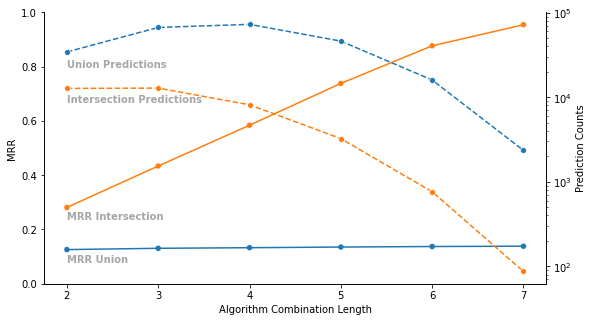

In [166]:
# MRR vs Prediction Counts on Algorithm Intersection/Union
fig,ax1=plt.subplots(figsize=(9,5))
ax2=ax1.twinx()

# plots
sns.lineplot(data=mrr_preds_df,x='len_combo_ls',y='mrr_ls',hue='group',markers='o', ax=ax1)
sns.scatterplot(data=mrr_preds_df,x='len_combo_ls',y='mrr_ls',hue='group',markers='o', ax=ax1)
sns.lineplot(data=mrr_preds_df,x='len_combo_ls',y='pred_ls',hue='group',marker='o',ax=ax2, linestyle='--')

# labels & spines
ax1.set(xlabel = 'Algorithm Combination Length', ylabel = 'MRR', ylim=(0,1.001))
ax2.set(ylabel = 'Prediction Counts', yscale = 'log')
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Manipulate the Legend, Get the handles and labels

ax1.annotate('MRR Intersection',xy=(2,.23), ha='left',va='bottom',color = 'black',alpha=0.35,weight='bold')
ax1.annotate('MRR Union',xy=(2,.07), ha='left',va='bottom',color = 'black',alpha=0.35,weight='bold')
ax1.annotate('Union Predictions', xy=(2,0.79),ha='left',va='bottom',color = 'black',alpha=0.35,weight='bold')
ax1.annotate('Intersection Predictions', xy=(2,0.66),ha='left',va='bottom',color = 'black',alpha=0.35,weight='bold')
ax1.get_legend().remove()
ax2.get_legend().remove()

plt.savefig("union_v_intersect_avg_rerank.png", dpi=400, bbox_inches="tight")
plt.show()

/tmp/ipykernel_269031/2426190168.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize = sz*.8)
/tmp/ipykernel_269031/2426190168.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize = sz*.8)
/tmp/ipykernel_269031/2426190168.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels(), fontsize = sz*.8)


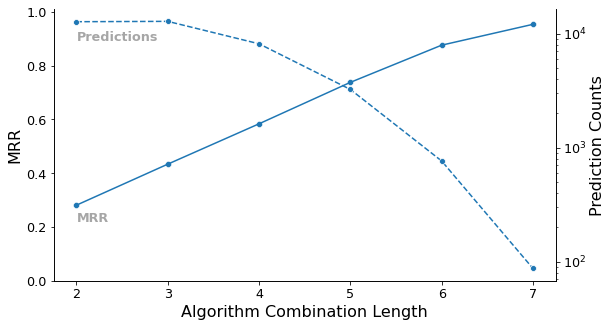

In [180]:
# Intersection Only

# MRR vs Prediction Counts on Algorithm Intersection/Union
fig,ax1=plt.subplots(figsize=(9,5))
ax2=ax1.twinx()

# plots
sns.lineplot(data=mrr_preds_df.query('group=="Intersect"'),x='len_combo_ls',y='mrr_ls',markers='o', ax=ax1)
sns.scatterplot(data=mrr_preds_df.query('group=="Intersect"'),x='len_combo_ls',y='mrr_ls',markers='o', ax=ax1)
sns.lineplot(data=mrr_preds_df.query('group=="Intersect"'),x='len_combo_ls',y='pred_ls',marker='o',ax=ax2, linestyle='--')

# labels & spines
sz= 16
ax1.set(xlabel = 'Algorithm Combination Length', ylabel = 'MRR', ylim=(0,1.011))
ax1.set_xlabel(ax1.get_xlabel(),fontsize= sz)
ax1.set_ylabel(ax1.get_ylabel(),fontsize = sz)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize = sz*.8)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize = sz*.8)
ax2.set(ylabel = 'Prediction Counts', yscale = 'log')
ax2.set_ylabel(ax2.get_ylabel(), fontsize = sz)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize = sz*.8)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Manipulate the Legend, Get the handles and labels

ax1.annotate('MRR',xy=(2,.21), ha='left',va='bottom',color = 'black',alpha=0.35,weight='bold',fontsize=sz*0.8)
#ax1.annotate('MRR Union',xy=(2,.07), ha='left',va='bottom',color = 'black',alpha=0.35,weight='bold')
#ax1.annotate('Union Predictions', xy=(2,0.79),ha='left',va='bottom',color = 'black',alpha=0.35,weight='bold')
ax1.annotate('Predictions', xy=(2,0.93),ha='left',va='top',color = 'black',alpha=0.35,weight='bold',fontsize=sz*0.8)

plt.savefig("intersect_avg_rerank.png", dpi=400, bbox_inches="tight")
plt.show()